# TOC
1) [Data Validation: First Look](#1-data-validation-first-look)
   1) [Imports and loading](#11-imports--loading)
   2) [Initial Look](#12-initial-look)
2) [Data Validation: changes/cleaning](#2-data-validation-changescleaning)
   1) [Initial Preparation](#21-initial-preparation)
   2) [Data cleaning](#22-data-cleaning)
   3) [Conclusion](#23-conclusion)
3) [EDA](#3-eda)
   1) [Age](#31-age)
   2) [Gender](#32-gender)
   3) [Visualize all features](#33-visualize-all-features)
   4) [Associations between features](#34-associations-between-features)
   5) [Drop further features](#35-drop-further-features)
4) [Feature Engineering, Extraction, Selection](#4-feature-engineering-extraction-selection)
   1) [Encode categoricals](#41-encode-categoricals)
   2) [Scale Features](#42-scale-features)
   3) [Dimensionality Reduction (PCA)](#43-dimensionality-reduction-pca)
5) [Clustering (k-Means)](#5-clustering-k-means)
   1) [determination of k-value](#51-determination-of-k-value)
   2) [clustering](#52-clustering)
6) [Evaluation of clusters](#6-evaluation-of-clusters)



# 1) Data Validation: First Look

## 1.1 imports & loading

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2_contingency


# CONSTANTS
BOLD: str = '\033[1m'
END: str = '\033[0m'

df: pd.DataFrame = pd.read_csv("dataset/mental-heath-in-tech-2016_20161114.csv")

## 1.2 Initial look

In [3]:
df.info()
# 1433 rows x 63 cols
# very long column names
# Several columns have null-elements, some barely have data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 63 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0   Are you self-employed?                                                                                                                                                            1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                                                        1146 non-null   object 
 2   Is your employer primarily a tech company/organization?     

In [4]:
df.head()

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",...,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,What country do you live in?,What US state or territory do you live in?,What country do you work in?,What US state or territory do you work in?,Which of the following best describes your work position?,Do you work remotely?
0,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,...,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes
1,0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,...,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never
2,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,...,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Sometimes,Sometimes,43,male,United Kingdom,NaN,United Kingdom,NaN,Supervisor/Team Lead,Sometimes
4,0,6-25,0.0,1.0,Yes,Yes,No,No,No,Neither easy nor difficult,...,Sometimes,Sometimes,43,Female,United States of America,Illinois,United States of America,Illinois,Executive Leadership|Supervisor/Team Lead|Dev ...,Sometimes


Which columns contain missing/empty/NaN values?

isna() Columns:
How many employees does your company or organization have?                                                                                                                           287
Is your employer primarily a tech company/organization?                                                                                                                              287
Is your primary role within your company related to tech/IT?                                                                                                                        1170
Does your employer provide mental health benefits as part of healthcare coverage?                                                                                                    287
Do you know the options for mental health care available under your employer-provided coverage?                                                                                      420
Has your employer ever formally discussed mental health (fo

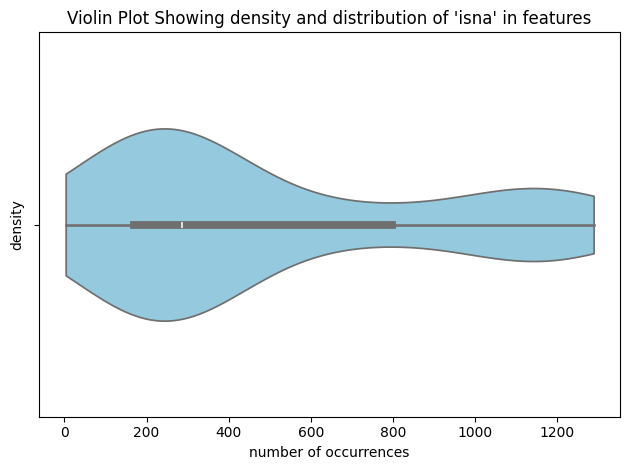

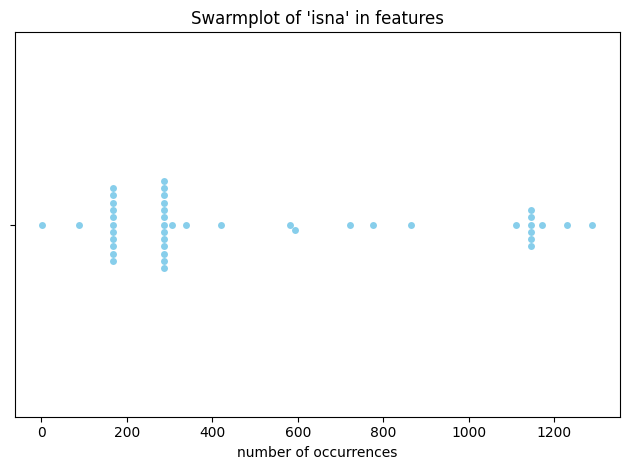

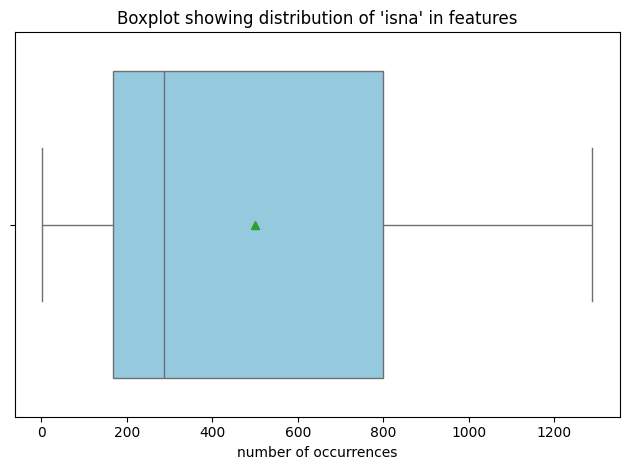

In [56]:
# Which columns contain missing/empty/NaN values?

print(f"{BOLD}isna() Columns:{END}")
#isna_cols = df.columns[df.isna().any()] 
#print(isna_cols)

isna_sum: pd.Series = df.isna().sum()
isna_sum = isna_sum[isna_sum > 0]
print(isna_sum)
print(max(isna_sum))

sns.violinplot(x=isna_sum, cut=0, color='skyblue', width=0.5,)
plt.title("Violin Plot Showing density and distribution of 'isna' in features")
plt.xlabel("number of occurrences")
plt.ylabel("density")
plt.tight_layout()
plt.savefig("final-violin_isna.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

sns.swarmplot(x=isna_sum, color='skyblue')
plt.title("Swarmplot of 'isna' in features")
plt.xlabel("number of occurrences")
plt.ylabel("")
plt.tight_layout()
plt.savefig("final-swarm-isna.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

sns.boxplot(x=isna_sum, showmeans=True, color='skyblue')
#ax.spines['left'].set_visible(False)
plt.title("Boxplot showing distribution of 'isna' in features")
plt.xlabel("number of occurrences")
#plt.ylabel("isna in features")
plt.tight_layout()
plt.savefig("final-boxplot_isna.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

In [6]:
# which categorical columns have many choices, sorted (descending)?
# note, this is done before data cleaning. Therefore, boolean columns which are represented as 'int' are not part of the analysis

df.select_dtypes(["object"]).nunique().sort_values(ascending=False)


Why or why not?                                                                                                                                                                     1085
Why or why not?.1                                                                                                                                                                   1080
Which of the following best describes your work position?                                                                                                                            264
If yes, what condition(s) have you been diagnosed with?                                                                                                                              128
If so, what condition(s) were you diagnosed with?                                                                                                                                    116
If maybe, what condition(s) do you believe you have?                       

# 2) Data Validation: changes/cleaning

## 2.1 Initial preparation

### 2.1.1 Renaming columns

In [7]:
# RENAME columns. The names are too long to work with comfortably.
# afterwards, store a lookup table in a dictionary

# dfr: df renamed
dfr = df.rename(
    columns = {
        df.columns[0]: "self_employed",
        df.columns[1]: "n_employees", # 100 & 500 are double-counted in the categories; bins not equidistant
        df.columns[2]: "employer_is_tech",
        df.columns[3]: "your_primary_role==tech",
        df.columns[4]: "employer_provides_HC-benefits",
        df.columns[5]: "know_HC-options",
        df.columns[6]: "employer_discussed_MH",
        df.columns[7]: "employer_resources_learnMH/help",
        df.columns[8]: "anonymity_protected",
        df.columns[9]: "MH_leave",
        df.columns[10]: "neg_conseq_discus_MH_w_employer",
        df.columns[11]: "neg_conseq_discus_PH_w_employer",
        df.columns[12]: "comfy_discus_MH_w_coworkers",
        df.columns[13]: "comfy_discus_MH_w_supervisor",
        df.columns[14]: "employer:MH==PH",
        df.columns[15]: "neg_conseq_coworkers_open_MH",
        df.columns[16]: "have_coverage_for_MH",
        df.columns[17]: "know_resources_help",
        df.columns[18]: "if_MH:reveal_to_clients/contacts",
        df.columns[19]: "if_revealed_client/contact:neg_impact",
        df.columns[20]: "if_MH:reveal_to_coworkers/employees",
        df.columns[21]: "if_revealed_cowork/empl:neg_impact",
        df.columns[22]: "productivity_influ_MH",
        df.columns[23]: "ifso,%_time_affected",
        df.columns[24]: "have_previous_employers",
        df.columns[25]: "previous_emplyrs_provided_MH",
        df.columns[26]: "aware_options_MH_prev_emplyrs",
        df.columns[27]: "prev_emplyrs_discuss_MH",
        df.columns[28]: "prev_emplyrs_resources_learnMH/help",
        df.columns[29]: "prev_emplyrs_anonymity_protected",
        df.columns[30]: "neg_conseq_discus_MH_w_prev_emplyrs",
        df.columns[31]: "neg_conseq_discus_PH_w_prev_emplyrs",
        df.columns[32]: "willing_discus_MH_prev_coworkers", 
        df.columns[33]: "willing_discus_MH_prev_supervisors", #Question implies previous supervisors, but doesn't actually state it!
        df.columns[34]: "prev_emplyrs:MH==PH",
        df.columns[35]: "neg_conseq_coworkers_MH_prev_emplyrs",
        df.columns[36]: "willing_talk_PH_interview",
        df.columns[37]: "36->Why/Not",
        df.columns[38]: "willing_talk_MH_interview",
        df.columns[39]: "38->Why/Not",
        df.columns[40]: "seenas_MH_hurt_career",
        df.columns[41]: "coworkers_more_neg_if_know_MH",
        df.columns[42]: "share_MH_friends/family",
        df.columns[43]: "bad_response_MH_current/prev_emplyrs",
        df.columns[44]: "witnessed_other_thus_less_likely_emplyr", # Doesn't specify if other witnessed individual was at current workplace
        df.columns[45]: "family_history_MH",
        df.columns[46]: "MH_in_past",
        df.columns[47]: "currently_MH",
        df.columns[48]: "47->Y:Which_MH",
        df.columns[49]: "47->Maybe:Which_MH",
        df.columns[50]: "diagnose_by_professional",
        df.columns[51]: "51->which_MH",
        df.columns[52]: "sought_MH_treatment_professional",
        df.columns[53]: "if_MH:when_treated:interferes_with_work",
        df.columns[54]: "if_MH:when_not_treated_well:interferes_with_work",
        df.columns[55]: "Age",
        df.columns[56]: "Gender",
        df.columns[57]: "country_living",
        df.columns[58]: "US_state_living",
        df.columns[59]: "country_working",
        df.columns[60]: "US_state_working",
        df.columns[61]: "work_position",
        df.columns[62]: "remote_work",
       
    }
)

# lookup dictionaries, both ways
# new_old: new to old
# old_new: old to new
new_old_colnames = {new: ori for ori, new in zip(df.columns, dfr.columns)}
old_new_colnames = {val: key for key, val in new_old_colnames.items()}

In [8]:
# showcasing the inconsistent categories: 2 categories include '100' as value
dfr["n_employees"].value_counts()

n_employees
26-100            292
More than 1000    256
100-500           248
6-25              210
500-1000           80
1-5                60
Name: count, dtype: int64

### Helper function

In [9]:
def describe_cols(dataframe: pd.DataFrame, 
                  lookup: dict[str, str] | None =None, 
                  slice : list[int] | None = None
                  ) -> None:
    """Helper function, to get the essentials out of a dataframe,
    in order to facilitate Data Validation

        input: a dataframe,
            (optional) an lookup dictionary of new -> old column names
            (optional) the column indexes you request, as a list, inclusive values
        return: None, only prints to console
    """
    if slice == None:
        slice = [0, len(dataframe.columns) - 1]

    if slice[1] > len(dataframe.columns) or slice[1] < 0:
        slice[1] = len(dataframe.columns) - 1
    if slice[0] < 0 or slice[0] > len(dataframe.columns) - 1:
        slice[0] = 0
    sl_range = range(slice[0], slice[1] + 1)

    df_length = len(dataframe)

    for i, col in enumerate(dataframe.columns):
        if i not in sl_range:
            continue
        
        print(f"{BOLD}col #{i}, name: {col}{END}") # header
        try:
            print(f"{BOLD}original name:{END} {lookup[col]}")
        except KeyError as e:
            pass

        print(f"{BOLD}dtype:{END} {dataframe[col].dtype}")
        print(f"{BOLD}isna:{END} {dataframe[col].isna().sum()} \
              (= {100*dataframe[col].isna().sum() / df_length:.1f}%)")
        print(f"{BOLD}unique:{END} ", dataframe[col].unique()) \
            if dataframe[col].dtype == 'object' else None
        #print(f"duplicates {dataframe.duplicated()}")
        
        print(f"{30 * "- "}") # --------------- divider
        
        print(dataframe[col].describe())
        
        print(f"{79*'#'}") # ############### divider

In [10]:
# testing & showing the function
describe_cols(dfr, new_old_colnames, [0,1])

col #0, name: self_employed
original name: Are you self-employed?
dtype: int64
isna: 0               (= 0.0%)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
count    1433.000000
mean        0.200279
std         0.400349
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: self_employed, dtype: float64
###############################################################################
col #1, name: n_employees
original name: How many employees does your company or organization have?
dtype: object
isna: 287               (= 20.0%)
unique:  ['26-100' '6-25' nan 'More than 1000' '100-500' '500-1000' '1-5']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
count       1146
unique         6
top       26-100
freq         292
Name: n_employees, dtype: object
###############################################################################


## 2.2 Data Cleaning
### Make copies

In [11]:
# Make copies
df_original = df.copy() # keep the original df
dfr_original = dfr.copy() # keep the original renamed df, for lookups

dfr_cleaned = dfr.copy() # work in this one

### Cols 0-10
#### Read Cols 0-10

In [12]:
describe_cols(dfr_original, new_old_colnames, [0,10])

#describe_cols(dfr_original, new_old_colnames, [0,1])
#describe_cols(dfr_original, new_old_colnames, [2,2])
#describe_cols(dfr_original, new_old_colnames, [3,4])
#describe_cols(dfr_original, new_old_colnames, [5,6])
#describe_cols(dfr_original, new_old_colnames, [7,8])
#describe_cols(dfr_original, new_old_colnames, [9,10])

col #0, name: self_employed
original name: Are you self-employed?
dtype: int64
isna: 0               (= 0.0%)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
count    1433.000000
mean        0.200279
std         0.400349
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: self_employed, dtype: float64
###############################################################################
col #1, name: n_employees
original name: How many employees does your company or organization have?
dtype: object
isna: 287               (= 20.0%)
unique:  ['26-100' '6-25' nan 'More than 1000' '100-500' '500-1000' '1-5']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
count       1146
unique         6
top       26-100
freq         292
Name: n_employees, dtype: object
###############################################################################
col #2, name: employer_is_tech
original name: Is your employer primarily a tech 

#### Amend cols 0-10

In [13]:
# Columns 0-10

### Col 0 #####################################################################
# name: self_employed
# original name: Are you self-employed?
col = "self_employed"
if col in dfr_cleaned.columns:
    dfr_cleaned[col].value_counts(normalize=True, dropna=False)
# This column will get dropped in the next section, as it brings no value
# to a company, which does typically not employ self-employed.

### Col 1 #####################################################################
# col #1, name: n_employees
# original name: How many employees does your company or organization have?
# isna: 287 (=20%)
# problems: 
# - double counting of the boundaries 100, 500
# - category bins are of vastly different sizes/ranges
col = "n_employees"
dfr_cleaned[col].value_counts(normalize=True, dropna=False)
dfr_cleaned[col].isna().sum() # 287 nan, all of them from "self_employed"

if "self_employed" in dfr_cleaned.columns:
    dfr_cleaned[(dfr_cleaned["self_employed"] == 1) & (dfr_cleaned["n_employees"].isna())].info()
# so all nulls are the self-employed, and they also null in other columns
# --> drop self-employed rows & drop self_employed column

# drop self-employed rows & drop self_employed column
col = "self_employed"
if col in dfr_cleaned.columns and any(dfr_cleaned[col] == 1):
    dfr_cleaned = dfr_cleaned.drop(dfr_cleaned[dfr_cleaned[col] == 1].index)
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

# check column again
col = "n_employees"
dfr_cleaned[col].isna().sum() # no more isna
dfr_cleaned[col].value_counts(normalize=True, dropna=False)

# except for the mentioned problems with the bin sizes and double counting,
# all is fine for use


### Col 2 #####################################################################
# name: employer_is_tech
# isna: 287 (=20%)
# but will be solved after dropping 'self_employed'
col = "employer_is_tech"
#dfr_cleaned[col].info()
#dfr_cleaned[col].isna().sum()
dfr_cleaned[col] = dfr_cleaned[col].astype(int)
dfr_cleaned[col].value_counts(dropna=False)

### Col 3 #####################################################################
# name: your_primary_role==tech
# original name: Is your primary role within your company related to tech/IT?
# isna: 1170 (= 82%)
### way too many isna. Drop column
col = "your_primary_role==tech"
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis=1)

### Col 4 #####################################################################
# name: employer_provides_HC-benefits
# isna: 287 (=20%) = the self-employed -> are dropped later
col = "employer_provides_HC-benefits"
#dfr_cleaned[col].value_counts(dropna=False)

### Col 5 #####################################################################
# name: know_HC-options
# original name: Do you know the options for mental health care available under your employer-provided coverage?
# isna: 420               (= 29.3%)
# edit: Too many isna -> drop column
col = "know_HC-options"
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis=1)


## FOLLOWING FUNCTIONS NOT DELETED, CAN BE REUSED FURTHER ALONG
##

#res = stats.mannwhitneyu(dfr_cleaned[dfr_cleaned[col].isna()]["Age"], dfr_cleaned[~dfr_cleaned[col].isna()]["Age"])
#print(res)
# ---------
#trim_diff = stats.trim_mean(dfr_cleaned[dfr_cleaned[col].isna()]["Age"], 0.1) - stats.trim_mean(dfr_cleaned[~dfr_cleaned[col].isna()]["Age"], 0.1)
#print(f"10% trimmed mean difference: {trim_diff:.1f} years")

# ------
"""
from statsmodels.distributions.empirical_distribution import ECDF

# Prepare data
answered = dfr_cleaned[~dfr_cleaned[col].isna()]["Age"].dropna()
missing = dfr_cleaned[dfr_cleaned[col].isna()]["Age"].dropna()

# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot
sns.boxplot(x=np.where(dfr_cleaned[col].isna(), "Missing", "Answered"), 
                y=dfr_cleaned["Age"], ax=ax1, showmeans=True, 
                meanprops={
                "marker": "+",
                  "markeredgecolor": "black",
                  "markersize": "10"})
ax1.set_title("Age Distribution by Response Status")
ax1.set_ylabel("Age")

# KDE
sns.kdeplot(answered, label="Answered", ax=ax2, fill=True)
sns.kdeplot(missing, label="Missing", ax=ax2, fill=True)
ax2.set_title("Kernel Density Estimation")
ax2.set_xlabel("Age")
ax2.legend()

# eCDF
ecdf_answered = ECDF(answered)
ecdf_missing = ECDF(missing)
x = np.linspace(min(min(answered), min(missing)), max(max(answered), max(missing)), 200)
ax3.plot(x, ecdf_answered(x), label='Answered')
ax3.plot(x, ecdf_missing(x), label='Missing')
ax3.set_title("Empirical CDF")
ax3.set_xlabel("Age")
ax3.set_ylabel("Cumulative Probability")
ax3.legend()

plt.tight_layout()
plt.show()
"""

### ----
"""
def permutation_test(x, y, n_permutations=10_000, test_stat='mean'):
        
    x, y = np.array(x), np.array(y)
    
    if test_stat == 'mean':
        obs_diff = np.mean(x) - np.mean(y)
    elif test_stat == 'median':
        obs_diff = np.median(x) - np.median(y)
    
    combined = np.concatenate([x, y])
    
    perm_diffs = np.zeros(n_permutations)
    
    for i in range(n_permutations):
        np.random.shuffle(combined)
        perm_x = combined[:len(x)]
        perm_y = combined[len(x):]
        
        if test_stat == 'mean':
            perm_diffs[i] = np.mean(perm_x) - np.mean(perm_y)
        elif test_stat == 'median':
            perm_diffs[i] = np.median(perm_x) - np.median(perm_y)
    
    pval = (np.abs(perm_diffs) >= np.abs(obs_diff)).mean()
    
    return pval, obs_diff

pval, effect = permutation_test(missing, answered, test_stat='mean')
print(f"Permutation p-value: {pval:.4f}, Effect size: {effect:.2f} years")
pval, effect = permutation_test(missing, answered, test_stat='median')
print(f"Permutation p-value: {pval:.4f}, Effect size: {effect:.2f} years")
"""

### Col 6 #####################################################################
# name: employer_discussed_MH
# original name: Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
# isna: 287 (= 20%) -> these will be gone after dropping col 'self_employed'
# everything fine
col = "employer_discussed_MH"
#dfr_cleaned[col].value_counts(dropna=False)

### Col 7 #####################################################################
# name: employer_resources_learnMH/help
# isna: 287 (= 20%) -> These will be gone after dropping col 'self_employed'
# everything fine
col = "employer_resources_learnMH/help"
#dfr_cleaned[col].value_counts(dropna=False)

### Col 8 #####################################################################
# name: anonymity_protected
# isna: 287 (= 20%) -> These will be gone after dropping col 'self_employed'
# all OK
col = "anonymity_protected"
#dfr_cleaned[col].value_counts(dropna=False)

### Col 9 #####################################################################
# name: MH_leave
# isna: 287 (= 20%) -> These will be gone after dropping col 'self_employed'
# all OK
col = "MH_leave"
#dfr_cleaned[col].value_counts(dropna=False)

### Col 10 ####################################################################
# name: neg_conseq_discus_MH_w_employer
# isna: 287 (= 20%) -> These will be gone after dropping col 'self_employed'
# all OK
col = "neg_conseq_discus_MH_w_employer"
#dfr_cleaned[col].value_counts(dropna=False)

col = None

<class 'pandas.core.frame.DataFrame'>
Index: 287 entries, 3 to 1429
Data columns (total 63 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   self_employed                                     287 non-null    int64  
 1   n_employees                                       0 non-null      object 
 2   employer_is_tech                                  0 non-null      float64
 3   your_primary_role==tech                           0 non-null      float64
 4   employer_provides_HC-benefits                     0 non-null      object 
 5   know_HC-options                                   0 non-null      object 
 6   employer_discussed_MH                             0 non-null      object 
 7   employer_resources_learnMH/help                   0 non-null      object 
 8   anonymity_protected                               0 non-null      object 
 9   MH_leave                 

### Cols 11-20
#### Read cols 11-20

In [14]:
describe_cols(dfr_original, new_old_colnames, [11,20])

#describe_cols(dfr_original, new_old_colnames, [11,12])
#describe_cols(dfr_original, new_old_colnames, [13,14])
#describe_cols(dfr_original, new_old_colnames, [15,16])
#describe_cols(dfr_original, new_old_colnames, [17,18])
#describe_cols(dfr_original, new_old_colnames, [19,20])

col #11, name: neg_conseq_discus_PH_w_employer
original name: Do you think that discussing a physical health issue with your employer would have negative consequences?
dtype: object
isna: 287               (= 20.0%)
unique:  ['No' nan 'Maybe' 'Yes']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
count     1146
unique       3
top         No
freq       837
Name: neg_conseq_discus_PH_w_employer, dtype: object
###############################################################################
col #12, name: comfy_discus_MH_w_coworkers
original name: Would you feel comfortable discussing a mental health disorder with your coworkers?
dtype: object
isna: 287               (= 20.0%)
unique:  ['Maybe' nan 'Yes' 'No']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
count      1146
unique        3
top       Maybe
freq        479
Name: comfy_discus_MH_w_coworkers, dtype: object
###############################################################################
col #13, name: com

#### Amend cols 11-20

In [15]:
## COL 11-20

### COL 11 ####################################################################
#name: neg_conseq_discus_PH_w_employer
# isna: 287 (= 20%) -> will be solved after dropping 'self_employed'
# all is fine
col = "neg_conseq_discus_PH_w_employer"
#dfr_cleaned[col].value_counts(dropna=False)

### COL 12 ####################################################################
# name: comfy_discus_MH_w_coworkers
# isna: 287 (= 20%) -> will be solved after dropping 'self_employed'
# all is ok
col = "comfy_discus_MH_w_coworkers"
#dfr_cleaned[col].value_counts(dropna=False)

### COL 13 ####################################################################
# name: comfy_discus_MH_w_supervisor
# isna: 287 (= 20%) -> will be solved after dropping 'self_employed'
# all OK
col = "comfy_discus_MH_w_supervisor"
dfr_cleaned[col].value_counts(dropna=False)

### COL 14 ####################################################################
# name: employer:MH==PH
# isna: 287 (= 20%) -> will be solved after dropping 'self_employed'
# all OK
col = "employer:MH==PH"
dfr_cleaned[col].value_counts(dropna=False)

### COL 15 ####################################################################
# name: neg_conseq_coworkers_open_MH
# isna: 287 (= 20%) -> will be solved after dropping 'self_employed'
col = "neg_conseq_coworkers_open_MH"
#dfr_cleaned[col].value_counts(dropna=False)
#dfr_cleaned[col].unique() # categorical, not int

### COL 16 ####################################################################
# name: have_coverage_for_MH
# isna: 1146 (= 80%)
col = "have_coverage_for_MH"
if col in dfr_cleaned.columns:
    dfr_cleaned[col].isna().sum() # still 1142 isna -> drop column
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

### COL 17 ####################################################################
# name: know_resources_help
# isna: 1146 (= 80%)
col = "know_resources_help"
if col in dfr_cleaned.columns:
    dfr_cleaned[col].isna().sum() # still 1142 isna -> drop column
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

### COL 18 ####################################################################
# name: if_MH:reveal_to_clients/contacts
# isna: 1146 (= 80%)
col = "if_MH:reveal_to_clients/contacts"
if col in dfr_cleaned.columns:
    dfr_cleaned[col].info() # still 1142 isna -> drop column
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

### COL 19 ####################################################################
# name: if_revealed_client/contact:neg_impact
# isna: 1289 (= 90%) --> way too many, drop column
col = "if_revealed_client/contact:neg_impact"
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

### COL 20 ####################################################################
# name: if_MH:reveal_to_coworkers/employees
# isna: 1146 (= 80%) --> too many, drop column
col = "if_MH:reveal_to_coworkers/employees"
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

<class 'pandas.core.series.Series'>
Index: 1146 entries, 0 to 1432
Series name: if_MH:reveal_to_clients/contacts
Non-Null Count  Dtype 
--------------  ----- 
0 non-null      object
dtypes: object(1)
memory usage: 17.9+ KB


### Cols 21-30
#### Read cols 21-30

In [16]:
describe_cols(dfr_original, new_old_colnames, [21,30])

#describe_cols(dfr_original, new_old_colnames, [21,22])
#describe_cols(dfr_original, new_old_colnames, [23,24])
#describe_cols(dfr_original, new_old_colnames, [25,26])
#describe_cols(dfr_original, new_old_colnames, [27,28])
#describe_cols(dfr_original, new_old_colnames, [29,30])

col #21, name: if_revealed_cowork/empl:neg_impact
original name: If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?
dtype: object
isna: 1146               (= 80.0%)
unique:  [nan "I'm not sure" 'No' 'Yes' 'Not applicable to me']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
count                      287
unique                       4
top       Not applicable to me
freq                       133
Name: if_revealed_cowork/empl:neg_impact, dtype: object
###############################################################################
col #22, name: productivity_influ_MH
original name: Do you believe your productivity is ever affected by a mental health issue?
dtype: object
isna: 1146               (= 80.0%)
unique:  [nan 'Yes' 'Not applicable to me' 'No' 'Unsure']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
count     287
unique      4
top       Yes
freq      204
Name: productivity_influ_MH, d

#### Amend cols 21-30

In [17]:
#### COL 21 ###################################################################
# name: if_revealed_cowork/empl:neg_impact
# as 80% is N/A, we will drop this column
col = "if_revealed_cowork/empl:neg_impact"
if col in dfr_cleaned.columns:
  dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

#### COL 22 ###################################################################
# name: productivity_influ_MH
# as 80% is N/A, we will drop this column
col = "productivity_influ_MH"
if col in dfr_cleaned.columns:
  dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

#### COL 23 ###################################################################
# name: ifso,%_time_affected
# as 86% is N/A, we will drop this column
col = "ifso,%_time_affected"
if col in dfr_cleaned.columns:
  dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

#### COL 24 ###################################################################
# name: have_previous_employers
# Everything fine.

#### COL 25 ###################################################################
# name: previous_emplyrs_provided_MH
# isna: 169 (= 12%)
# We will combine isna with "I don't know" (=22%), combined = (33.6%)
col = "previous_emplyrs_provided_MH"
dfr_cleaned[col] = (dfr_cleaned[col]
                                               .fillna('Unknown')
                                               .replace("I don't know","Unknown")
                                               )
#dfr_cleaned["previous_emplyrs_provided_MH"].value_counts(normalize=True, dropna=False)

#### COL 26 ###################################################################
# name: aware_options_MH_prev_emplyrs
# isna: 169 (= 12%)
# We will combine isna with 'N/A (not currently aware)' (=41%), combined = (53%)

col = "aware_options_MH_prev_emplyrs"
dfr_cleaned[col] = (dfr_cleaned[col]
                                               .fillna('Unknown')
                                               .replace(
                                                 "N/A (not currently aware)",
                                                 "Unknown")
                                               )
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 27 ###################################################################
# name: prev_emplyrs_discuss_MH
# isna: 169 (= 12%)
# We will combine isna with "I don't know" () (=6%), combined = (18%)
col = "prev_emplyrs_discuss_MH"
#dfr[col].value_counts(normalize=True, dropna=False)
dfr_cleaned[col] = (dfr_cleaned[col]
                                               .fillna('Unknown')
                                               .replace("I don't know",
                                                        "Unknown")
                                               )
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 28 ###################################################################
# name: prev_emplyrs_resources_learnMH/help
# isna: 169 (= 12%)
col = "prev_emplyrs_resources_learnMH/help"
# could have dealt with the "missingness". Attempted in the section below.
# ultimately, decided to drop
if col in dfr_cleaned.columns:
  dfr_cleaned = dfr_cleaned.drop(col, axis = 1)


"""
# TODO: FINISH THE ANALYSIS HERE
#### COL 28 ###################################################################
# name: prev_emplyrs_resources_learnMH/help
# isna: 169 (= 12%)
col = "prev_emplyrs_resources_learnMH/help"
#dfr[col].value_counts(normalize=True, dropna=False)
## As it is 12% of values, and it can't be combined with an other "Unknown"
## category, another approach is needed.
# to look if there is a difference in the numerical columns, in the rows which are isna
# or which are not isna
print(dfr.groupby(dfr[col].isna()).mean(numeric_only=True))
# there is a difference in the numerical columns.
# we must decide wether this difference is significant or not
#
# if there is a significant difference, it is unlikely to be MCAR
# but is probably MNAR OR MAR

# -----------------------------------------------------------------------------
# begin
# -----------------------------------------------------------------------------

## However, the age column hasn't been cleaned yet! 

# TODO: run again after all columns have been cleaned for more truthful results
testcol = "Age"
dfr['is_missing'] = dfr[col].isna()
group1 = dfr[dfr['is_missing']][testcol].dropna()
group2 = dfr[~dfr['is_missing']][testcol].dropna()


# Shapiro Wilk:
print(stats.shapiro(group1), stats.shapiro(group2))

# Levene's test (H°: equal variance)
_, p_value = stats.levene(group1, group2)
print(f"Levene's p-value: {p_value:.4f}")  # p < 0.05 → reject H0 (heteroscedasticity)
# with uncleaned data: p-val is 0.47 -> h° -> equal variance
# Thus, t-test will be fine to use now

_, p_value = stats.ttest_ind(group1, group2, equal_var=True)
print(f"Student t: {p_value:.3}")
# Student t: 1.54e-05 -> different distribution

_, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney p-value: {p_value:.3}")
# Mann-Whitney p-value: 1.36e-12 -> different distribution

# -----------------------------------------------------------------------------
# end
# -----------------------------------------------------------------------------
"""


#### COL 29 ###################################################################
# name: prev_emplyrs_anonymity_protected
# isna: 169 (= 12%)
col = "prev_emplyrs_anonymity_protected"
# dfr[col].value_counts(normalize=True, dropna=False)

# I don't know    0.600140
# NaN             0.117934
# Yes, always     0.114445
# No              0.084438
# Sometimes       0.083043

dfr_cleaned[col] = (dfr_cleaned[col]
                                               .fillna('Unknown')
                                               .replace("I don't know","Unknown")
                                               )

#dfr_cleaned[col].value_counts(normalize=True, dropna=False)



#### COL 30 ###################################################################
# name: neg_conseq_discus_MH_w_prev_emplyrs
# isna: 169 (= 12%)
col = "neg_conseq_discus_MH_w_prev_emplyrs"
#dfr[col].value_counts(normalize=True, dropna=False)
# Some of them        0.429170
# I don't know        0.216329
# Yes, all of them    0.157711
# NaN                 0.117934
# None of them        0.078856
dfr_cleaned[col] = (dfr_cleaned[col]
                                               .fillna('Unknown')
                                               .replace("I don't know","Unknown")
                                               )
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

### Cols 31-40

#### Read cols 31-40

In [18]:
describe_cols(dfr_original, new_old_colnames, [31,40])

#describe_cols(dfr_original, new_old_colnames, [31,32])
#describe_cols(dfr_original, new_old_colnames, [33,34])
#describe_cols(dfr_original, new_old_colnames, [35,36])
#describe_cols(dfr_original, new_old_colnames, [37,38])
#describe_cols(dfr_original, new_old_colnames, [39,40])

col #31, name: neg_conseq_discus_PH_w_prev_emplyrs
original name: Do you think that discussing a physical health issue with previous employers would have negative consequences?
dtype: object
isna: 169               (= 11.8%)
unique:  ['None of them' 'Some of them' 'Yes, all of them' nan]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
count             1264
unique               3
top       Some of them
freq               631
Name: neg_conseq_discus_PH_w_prev_emplyrs, dtype: object
###############################################################################
col #32, name: willing_discus_MH_prev_coworkers
original name: Would you have been willing to discuss a mental health issue with your previous co-workers?
dtype: object
isna: 169               (= 11.8%)
unique:  ['Some of my previous employers' 'No, at none of my previous employers'
 'Yes, at all of my previous employers' nan]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
count                          

#### Amend cols 31-40

In [19]:
#### COL 31 ###################################################################
# name: neg_conseq_discus_PH_w_prev_emplyrs
# isna: 169 (= 12%)

col = "neg_conseq_discus_PH_w_prev_emplyrs"
#dfr[col].value_counts(normalize=True, dropna=False)
dfr_cleaned[col] = (dfr_cleaned[col].fillna('Unknown'))
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 32 ###################################################################
# name: willing_discus_MH_prev_coworkers
# isna: 169 (= 12%)
col = "willing_discus_MH_prev_coworkers"
#dfr[col].value_counts(normalize=True, dropna=False)
dfr_cleaned[col] = (dfr_cleaned[col].fillna('Unknown'))
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 33 ###################################################################
# name: willing_discus_MH_prev_supervisors
# isna: 169 (= 12%)
col = "willing_discus_MH_prev_supervisors"
#dfr[col].value_counts(normalize=True, dropna=False)
dfr_cleaned[col] = (dfr_cleaned[col]
                                               .fillna('Unknown')
                                               .replace("I don't know","Unknown")
                                               )
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 34 ###################################################################
# name: prev_emplyrs:MH==PH
# isna: 169 (= 12%)
col = "prev_emplyrs:MH==PH"
#dfr[col].value_counts(normalize=True, dropna=False)
dfr_cleaned[col] = (dfr_cleaned[col]
                                               .fillna('Unknown')
                                               .replace("I don't know","Unknown")
                                               )
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 35 ###################################################################
# name: neg_conseq_coworkers_MH_prev_emplyrs
# isna: 169 (= 12%)
col = "neg_conseq_coworkers_MH_prev_emplyrs"
#dfr[col].value_counts(normalize=True, dropna=False)
dfr_cleaned[col] = dfr_cleaned[col].fillna('Unknown')
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 36 ###################################################################
# name: willing_talk_PH_interview
# all OK
col = "willing_talk_PH_interview"
#dfr_cleaned[col] = dfr[col]
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 37 ###################################################################
# name: name: 36->Why/Not
# isna: 338 (= 24%)
col = "36->Why/Not"
#dfr[col].value_counts(normalize=True, dropna=False)
# useless column, there are way too many different answers. use TF-IDF perhaps
# -> we will drop it.
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

#### COL 38 ###################################################################
# name: willing_talk_MH_interview
# everything fine.
col = "willing_talk_MH_interview"
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)
#dfr_cleaned[col] = dfr[col]

#### COL 39 ###################################################################
# name: 38->Why/Not
col = "38->Why/Not"
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)
#dfr_cleaned[col].nunique()
# useless column, there are way too many different answers. use TF-IDF perhaps
# -> we will drop it.
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

#### COL 40 ###################################################################
# name: seenas_MH_hurt_career
# ori: Do you feel that being identified as a person with a mental health issue 
# would hurt your career?
# ---> ca 9.3% has MH, and has an answer based on experience
# ---> ca 50% is conjecturing
#
col = "seenas_MH_hurt_career"
dfr_cleaned[col].value_counts(normalize=True, dropna=False)
#dfr_cleaned[col] = dfr[col]
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)


seenas_MH_hurt_career
Maybe                         0.411867
Yes, I think it would         0.390052
No, I don't think it would    0.105585
Yes, it has                   0.070681
No, it has not                0.021815
Name: proportion, dtype: float64

### Cols 41-50
#### Read cols 41-50

In [20]:
describe_cols(dfr_original, new_old_colnames, [41,50])

#describe_cols(dfr_original, new_old_colnames, [41,42])
#describe_cols(dfr_original, new_old_colnames, [43,44])
#describe_cols(dfr_original, new_old_colnames, [45,46])
#describe_cols(dfr_original, new_old_colnames, [47,48])
#describe_cols(dfr_original, new_old_colnames, [49,50])
#describe_cols(dfr_original, new_old_colnames, [50,50])

col #41, name: coworkers_more_neg_if_know_MH
original name: Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?
dtype: object
isna: 0               (= 0.0%)
unique:  ["No, I don't think they would" 'Maybe' 'Yes, they do'
 'Yes, I think they would' 'No, they do not']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
count      1433
unique        5
top       Maybe
freq        591
Name: coworkers_more_neg_if_know_MH, dtype: object
###############################################################################
col #42, name: share_MH_friends/family
original name: How willing would you be to share with friends and family that you have a mental illness?
dtype: object
isna: 0               (= 0.0%)
unique:  ['Somewhat open' 'Neutral'
 'Not applicable to me (I do not have a mental illness)' 'Very open'
 'Not open at all' 'Somewhat not open']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
count  

#### Amend cols 41-50

In [21]:
#### COL 41 ##################################################################
# name: coworkers_more_neg_if_know_MH
# fine, do nothing
col = "coworkers_more_neg_if_know_MH"
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 42 ##################################################################
# name: share_MH_friends/family
# fine, do nothing
col = "share_MH_friends/family"
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)


#### COL 43 ##################################################################
# name: bad_response_MH_current/prev_emplyrs
# isna: 89 (=6%)
col = "bad_response_MH_current/prev_emplyrs"
#dfr[col].value_counts(normalize=True, dropna=False)
dfr_cleaned[col] = (dfr_cleaned[col]
                                               .fillna('Unsure/Unknown')
                                               .replace("Maybe/Not sure","Unsure/Unknown")
                                               )
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 44 ##################################################################
# name: witnessed_other_thus_less_likely_emplyr
# isna: 776 (= 54%)
# --> too many isna, drop column
col = "witnessed_other_thus_less_likely_emplyr"
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

#### COL 45 ##################################################################
# name: family_history_MH
# do nothing, everything fine
col = "family_history_MH"
#dfr[col].value_counts(normalize=True, dropna=False)
#dfr_cleaned[col] = dfr[col]
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 46 ##################################################################
# name: MH_in_past
# everything OK, do nothing
col = "MH_in_past"
#dfr[col].value_counts(normalize=True, dropna=False)
#dfr_cleaned[col] = dfr[col]
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 47 ##################################################################
# name: currently_MH
# all ok, do nothing
col = "currently_MH"
#dfr[col].value_counts(normalize=True, dropna=False)
#dfr_cleaned[col] = dfr[col]
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 48 ##################################################################
#name: 47->Y:Which_MH
# isna: 865 (= 60.4%)
# 128 unique values.
# --> drop the column
col = "47->Y:Which_MH"
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

#### COL 49 ##################################################################
# name: 47->Maybe:Which_MH
# isna: 1111 (= 77.5%)
# drop column
col = "47->Maybe:Which_MH"
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

#### COL 50 ##################################################################
# name: diagnose_by_professional
# everything fine
col = "diagnose_by_professional"
#dfr_cleaned[col] = dfr[col]

### Cols 51-62
#### Read cols 51-62

In [22]:
describe_cols(dfr_original, new_old_colnames, [51,62])

#describe_cols(dfr_original, new_old_colnames, [51,52])
#describe_cols(dfr_original, new_old_colnames, [53,54])
#describe_cols(dfr_original, new_old_colnames, [55,56])
#describe_cols(dfr_original, new_old_colnames, [57,58])
#describe_cols(dfr_original, new_old_colnames, [59,60])
#describe_cols(dfr_original, new_old_colnames, [61,62])

col #51, name: 51->which_MH
original name: If so, what condition(s) were you diagnosed with?
dtype: object
isna: 722               (= 50.4%)
unique:  ['Anxiety Disorder (Generalized, Social, Phobia, etc)'
 'Anxiety Disorder (Generalized, Social, Phobia, etc)|Mood Disorder (Depression, Bipolar Disorder, etc)'
 nan
 'Anxiety Disorder (Generalized, Social, Phobia, etc)|Substance Use Disorder'
 'Mood Disorder (Depression, Bipolar Disorder, etc)'
 'Anxiety Disorder (Generalized, Social, Phobia, etc)|Obsessive-Compulsive Disorder'
 'Personality Disorder (Borderline, Antisocial, Paranoid, etc)|Attention Deficit Hyperactivity Disorder'
 'Mood Disorder (Depression, Bipolar Disorder, etc)|Attention Deficit Hyperactivity Disorder|Post-traumatic Stress Disorder'
 'Anxiety Disorder (Generalized, Social, Phobia, etc)|Mood Disorder (Depression, Bipolar Disorder, etc)|Substance Use Disorder|Addictive Disorder'
 'Anxiety Disorder (Generalized, Social, Phobia, etc)|Attention Deficit Hyperactivity Disord

#### Amend cols 51-62

In [23]:
#### COL 51 ###################################################################
# name: 51->which_MH
# isna: 722 (= 50.4%)
# --> drop 
col = "51->which_MH"
#dfr_cleaned[col]
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

#### COL 52 ###################################################################
# name: sought_MH_treatment_professional
# binary, everything fine
# all OK
col = "sought_MH_treatment_professional"
#dfr_cleaned[col] = dfr[col]

#### COL 53 ###################################################################
# name: if_MH:when_treated:interferes_with_work
# all OK
col = "if_MH:when_treated:interferes_with_work"
#dfr[col].value_counts(normalize=True, dropna=False)
#dfr_cleaned[col] = dfr[col]
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 54 ###################################################################
# name: if_MH:when_not_treated_well:interferes_with_work
# all OK
col = "if_MH:when_not_treated_well:interferes_with_work"
#dfr[col].value_counts(normalize=True, dropna=False)
#dfr_cleaned[col] = dfr[col]
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

#### COL 55 ###################################################################
# name: Age
# some weird values: 3, 15, 17, 99, 323
col = "Age"

dfr_cleaned.loc[dfr_cleaned[col] < 18, ['Age']] # 3, 15, 17 are underage, likely not employed
dfr_cleaned.loc[dfr_cleaned[col] > 65, ['Age']] # 66, 70, 74, 99, 323
# let's drop the underage, and the 99 and 323-year olds values.
# 66, 70, 74 years old could still be employed and representative
if col in dfr_cleaned.columns and any(dfr_cleaned[col] < 18):
    dfr_cleaned = dfr_cleaned.drop(dfr_cleaned[dfr_cleaned[col] < 18].index)
if col in dfr_cleaned.columns and any(dfr_cleaned[col] >= 99):
    dfr_cleaned = dfr_cleaned.drop(dfr_cleaned[dfr_cleaned[col] >= 99].index)
#dfr_cleaned.Age.describe()



#### COL 56 ###################################################################
# name: Gender
# isna: 3 (= 0.2%)
dfr_cleaned["Gender"] = dfr_cleaned.Gender.replace({
    'M':'Male',
    'm':'Male',
    'f':'Female',
    'F':'Female',
})
dfr_cleaned["Gender"] = (dfr_cleaned.Gender
                         .str.strip()
                         .str.lower()
                         .replace({
                             "female":"Female",
                             "woman":"Female",
                             "male":"Male",
                             "man":"Male",
                             }))
dfr_cleaned["Gender"] = dfr_cleaned.Gender.fillna("Other")

dfr_cleaned["Gender"] = dfr_cleaned.Gender.where(
    lambda x: x.isin(["Female","Male"]), "Other")

#print(dfr_cleaned.Gender.unique())
#dfr_cleaned.Gender.value_counts(normalize=True, dropna=False)


#### COL 57 ###################################################################
# name: country_living
# no duplicates or alternative spellings
# sorted(dfr_cleaned.country_living.unique())
# all OK
col = "country_living"
# dfr_cleaned[col].value_counts(normalize=False)
# dfr_cleaned[col].value_counts(normalize=True).cumsum()
# Up to France, we have cumulative 90% of all counts.
counts = dfr_cleaned[col].value_counts()
dfr_cleaned[col] = dfr_cleaned[col].apply(lambda x: x if counts[x] >= 11 else "Other")


#### COL 58 ###################################################################
# col #58, name: US_state_living
# original name: What US state or territory do you live in?
# isna: 593 (= 41%)
# drop, too many isna
col = "US_state_living"
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)


#### COL 59 ###################################################################
# name: country_working
# TODO: feature engineering: add column 'immigrant' is living != working
col = "country_working"
# dfr_cleaned[col].value_counts(normalize=True, dropna=False)
# sorted(dfr_cleaned.country_working.unique())
# dfr_cleaned[col].value_counts(normalize=False)
# dfr_cleaned[col].value_counts(normalize=True).cumsum()
# Up to France, we have cumulative 90% of all counts.
counts = dfr_cleaned[col].value_counts()
dfr_cleaned[col] = dfr_cleaned[col].apply(lambda x: x if counts[x] >= 11 else "Other")

counts = None


#### COL 60 ###################################################################
# name: US_state_working
# isna: 582               (= 40.6%)
# drop, too many isna
col = "US_state_working"
if col in dfr_cleaned.columns:
    dfr_cleaned = dfr_cleaned.drop(col, axis = 1)

#### COL 61 ###################################################################
# name: work_position
# the directory-like structure will be reduced to only the first value
col = "work_position"
dfr_cleaned[col] = dfr_cleaned[col].str.split('|', n=1).str[0].str.strip()
#dfr_cleaned[col].describe()

#### COL 62 ###################################################################
# name: remote_work
# all OK
col = "remote_work"
#dfr_cleaned[col].value_counts(normalize=True, dropna=False)

col = None

In [24]:
# Besides 'Age', the others are binary categoricals, need to be re-assigned.
# print("numerical columns (some actually categorical):")
# dfr_cleaned.select_dtypes(include=['number']).columns 

dfr_cleaned['have_previous_employers'] = dfr_cleaned['have_previous_employers'].astype('object')
dfr_cleaned['sought_MH_treatment_professional'] = dfr_cleaned['sought_MH_treatment_professional'].astype('object')

dfr_cleaned['employer_is_tech'] = dfr_cleaned['employer_is_tech'].astype('object') # The only column stored as 'category', amend for consistency
dfr_cleaned.select_dtypes(include=['number']).columns

Index(['Age'], dtype='object')

## 2.3 Conclusion

In [ ]:
dfr_cleaned.isna().sum() # check: no more null values
dfr_cleaned.info()
dfr_cleaned.shape ## 1142 rows x 43 columns

# we came from 1433 rows x 63 cols

# so we removed 20 columns, and 291 rows (= ca 20% of rows)
# 287 out of the 291 were the self-employed
# 4 others are Age-related

<class 'pandas.core.frame.DataFrame'>
Index: 1142 entries, 0 to 1432
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   n_employees                                       1142 non-null   object
 1   employer_is_tech                                  1142 non-null   object
 2   employer_provides_HC-benefits                     1142 non-null   object
 3   employer_discussed_MH                             1142 non-null   object
 4   employer_resources_learnMH/help                   1142 non-null   object
 5   anonymity_protected                               1142 non-null   object
 6   MH_leave                                          1142 non-null   object
 7   neg_conseq_discus_MH_w_employer                   1142 non-null   object
 8   neg_conseq_discus_PH_w_employer                   1142 non-null   object
 9   comfy_discus_MH_w_coworkers        

(1142, 43)

# 3) EDA

Only the 'Age' column is numerical, all other columns are categorical.

## 3.1 Age

mean Age: 33.3861646234676
median Age: 32.0
std_dev Age: 7.693555665225739


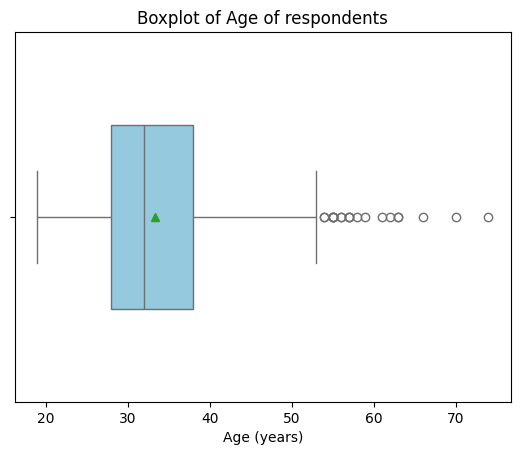

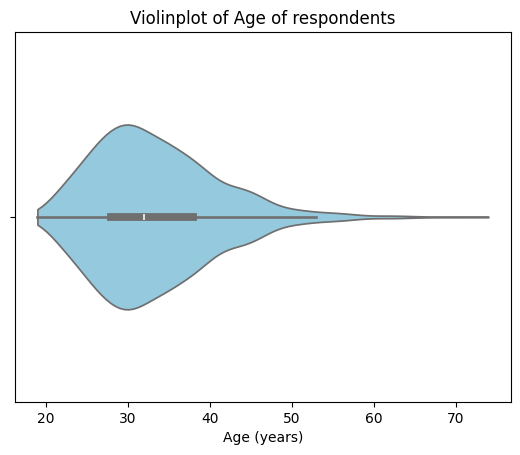

c:\Users\patrick\Documents\DEV-PROJECTS\UnsupML\jupyter_env\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 18.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


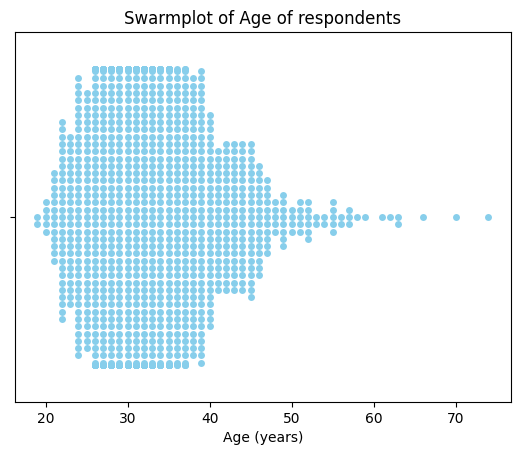

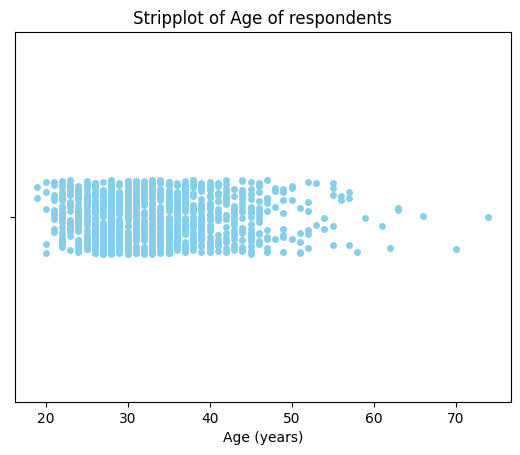

In [26]:
print("mean Age:", dfr_cleaned['Age'].mean())
print("median Age:", dfr_cleaned['Age'].median())
print("std_dev Age:", dfr_cleaned['Age'].std())

#plt.rcParams['figure.dpi'] = 120
sns.boxplot(data=dfr_cleaned, x='Age', color='skyblue', width=0.5, orient='h', showmeans=True)
mean_age = dfr_cleaned['Age'].mean()
#plt.axvline(mean_age, color='red', linestyle='--', label=f'Mean: {mean_age:.1f}')
plt.title('Boxplot of Age of respondents')
plt.ylabel('')
plt.xlabel('Age (years)')
plt.savefig("final-boxplot_age.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

sns.violinplot(data=dfr_cleaned, x='Age', color='skyblue', width=0.5, orient='h', cut = 0)
plt.title("Violinplot of Age of respondents")
plt.ylabel("")
plt.xlabel("Age (years)")
plt.savefig("final-violin_age.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

sns.swarmplot(data=dfr_cleaned, x='Age', color='skyblue')
plt.title("Swarmplot of Age of respondents")
plt.ylabel("")
plt.xlabel("Age (years)")
plt.savefig("final-swarm.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

sns.stripplot(data=dfr_cleaned, x='Age', color='skyblue')
plt.title("Stripplot of Age of respondents")
plt.ylabel("")
plt.xlabel("Age (years)")
plt.savefig("final-stripplot_age.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

## 3.2 Gender

Gender
Male      832
Female    259
Other      51
Name: count, dtype: int64 

Gender
Male      0.729
Female    0.227
Other     0.045
Name: proportion, dtype: float64


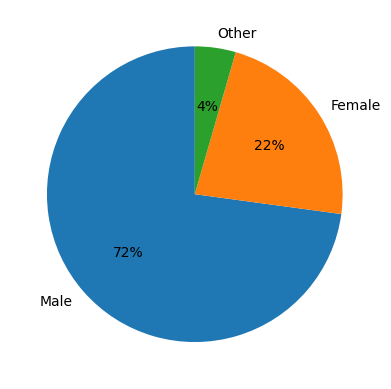

In [27]:
print(dfr_cleaned["Gender"].value_counts(), "\n")
print(dfr_cleaned["Gender"].value_counts(normalize=True).round(3))

plt.pie(dfr_cleaned["Gender"].value_counts(), 
        labels = dfr_cleaned["Gender"].value_counts().index,
        autopct="%1d%%",
        startangle = 90)
#plt.savefig("final-gender-pie.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

## 3.3 Visualize all Features

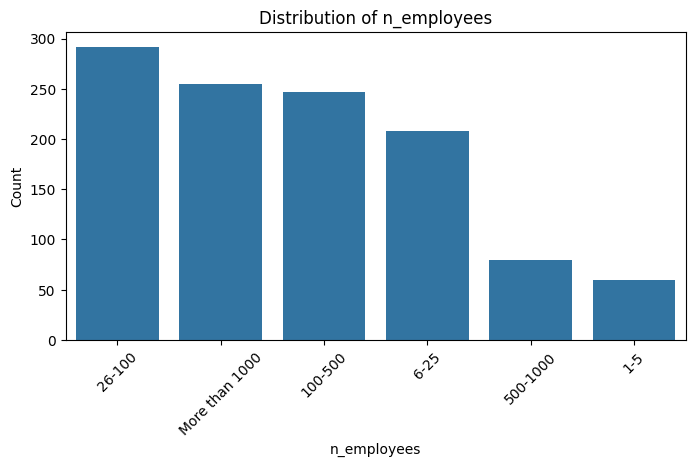

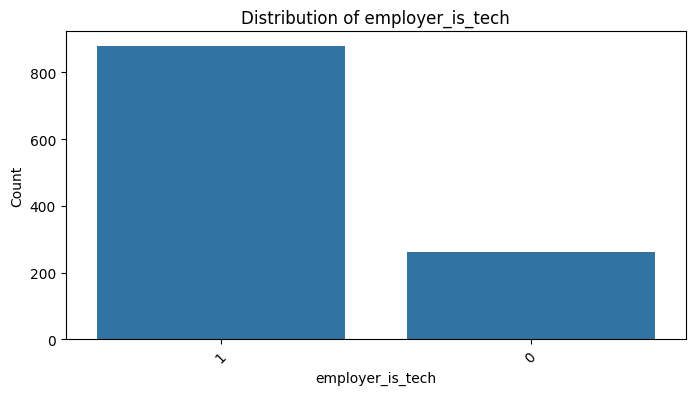

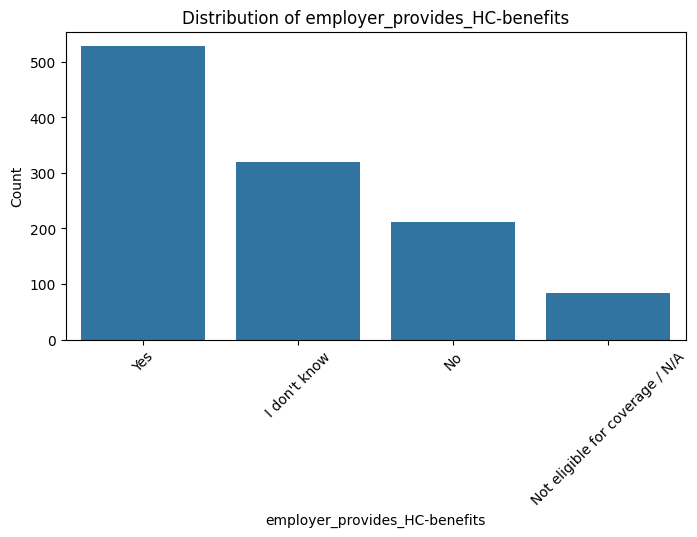

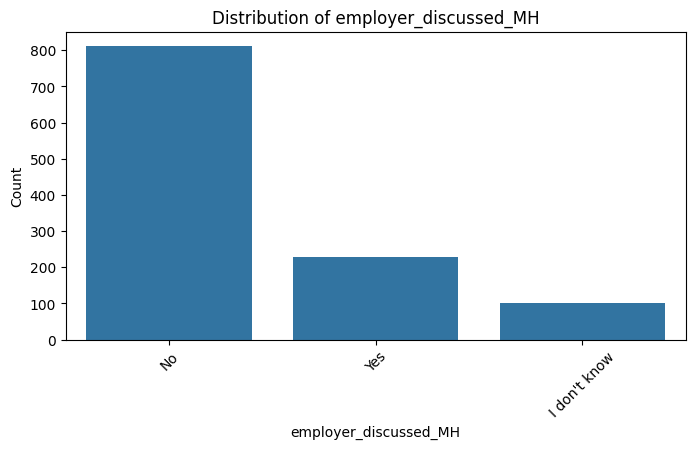

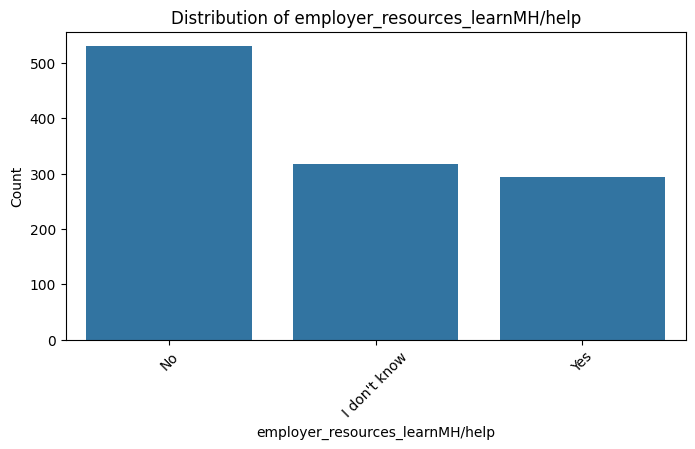

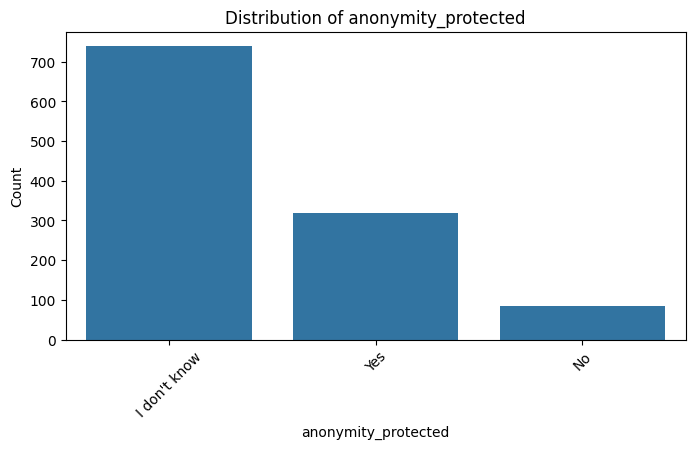

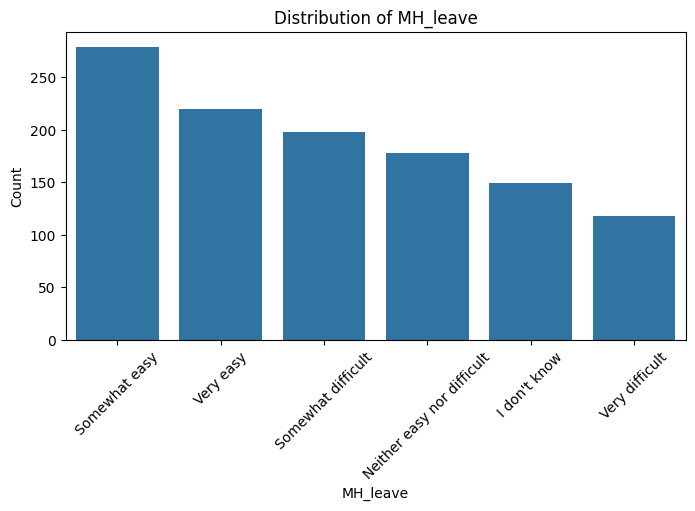

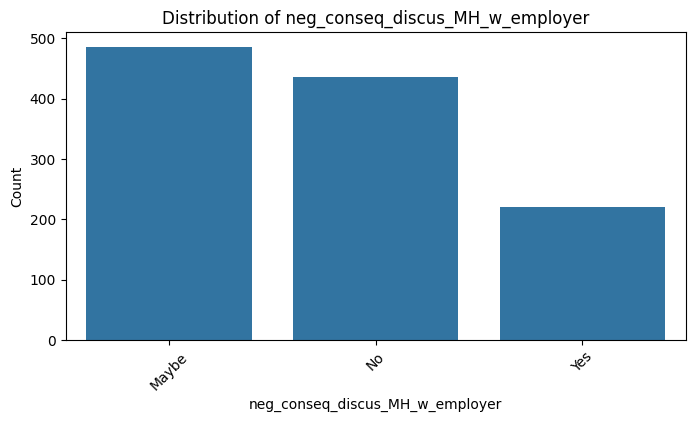

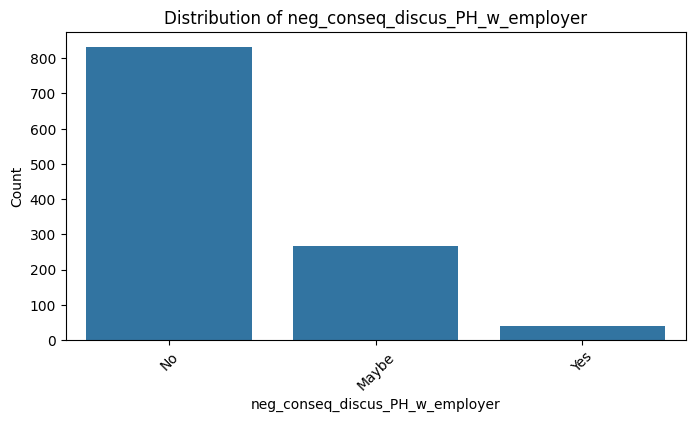

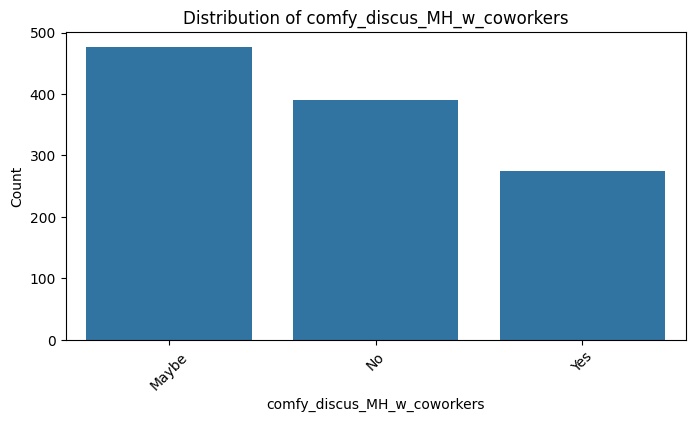

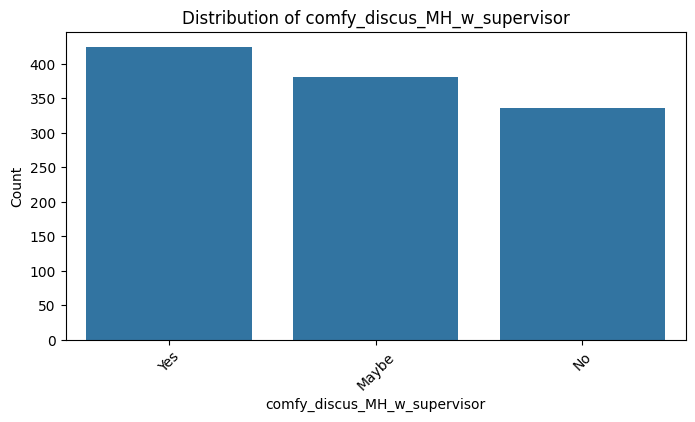

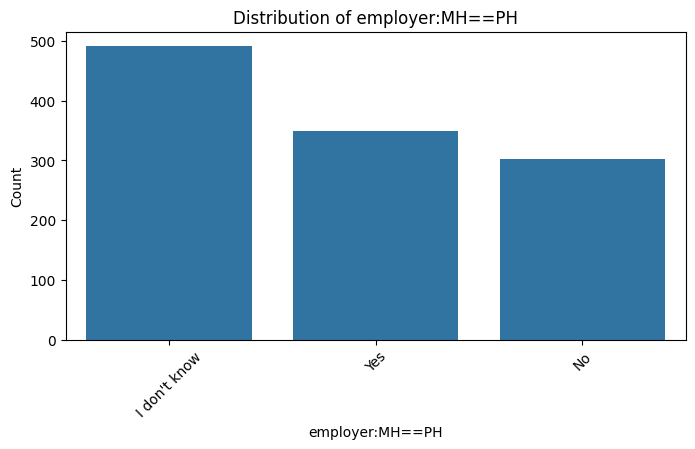

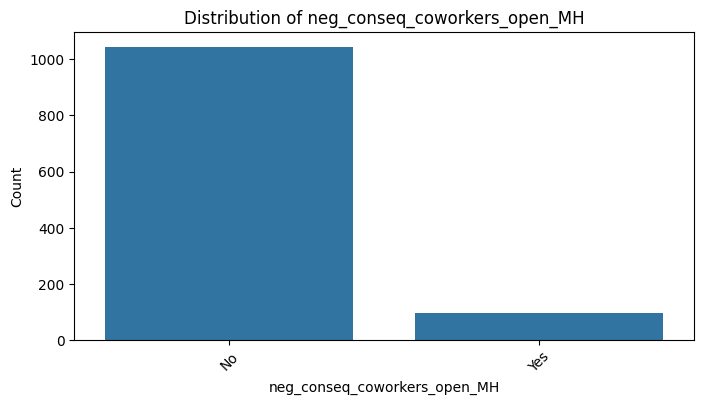

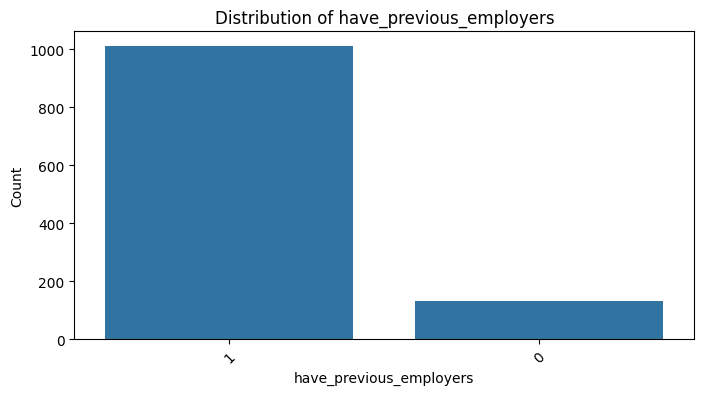

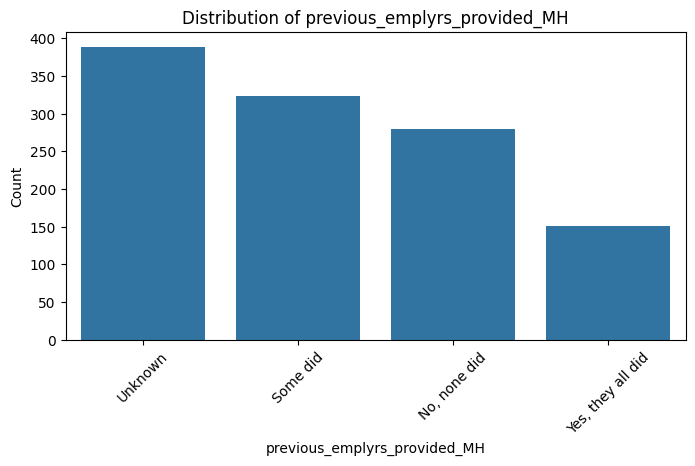

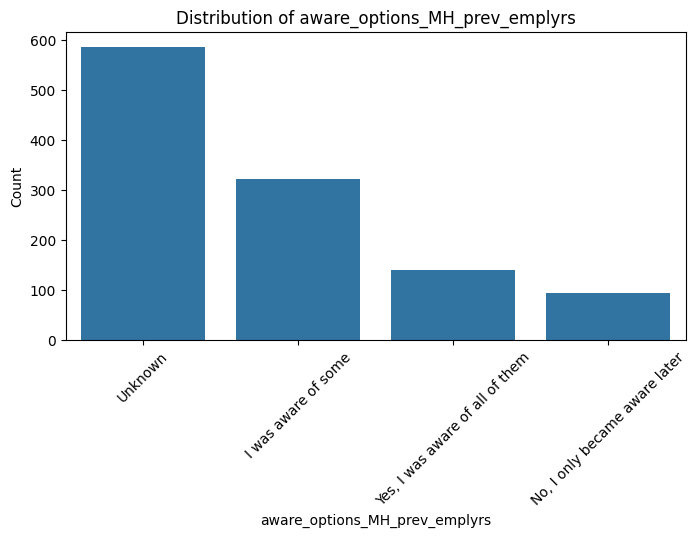

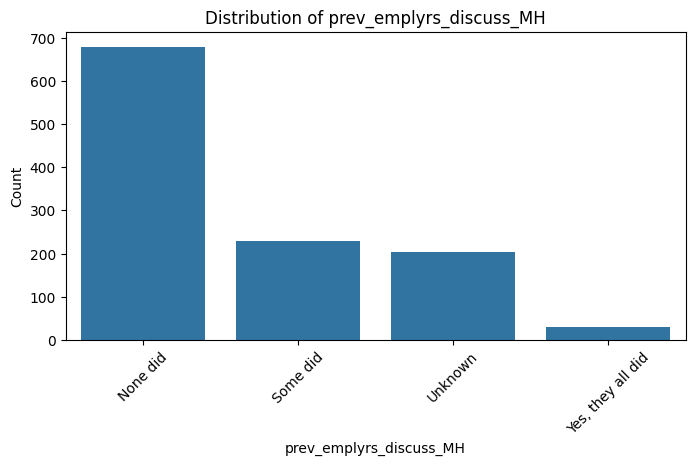

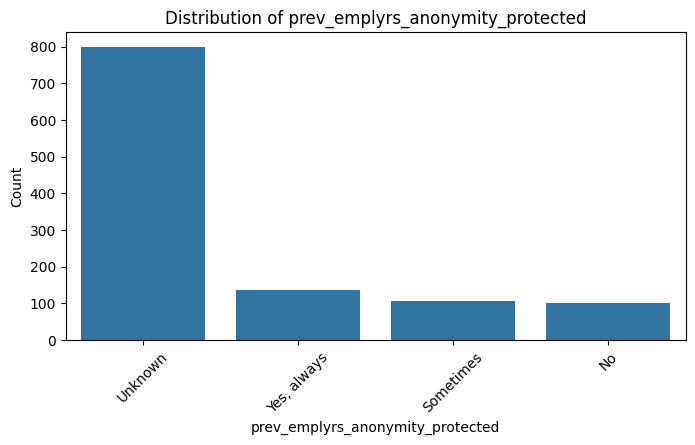

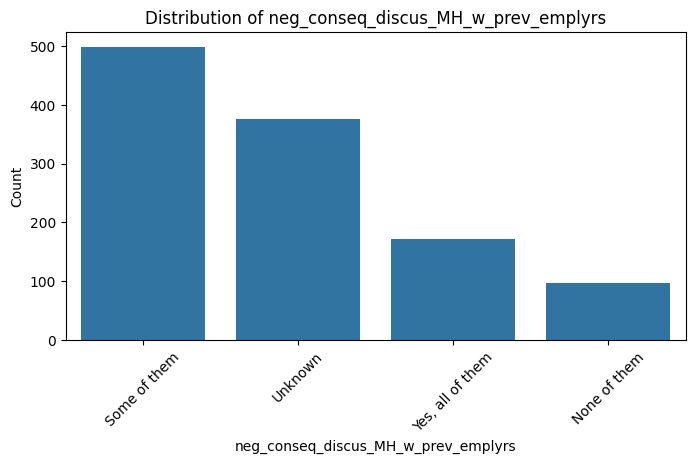

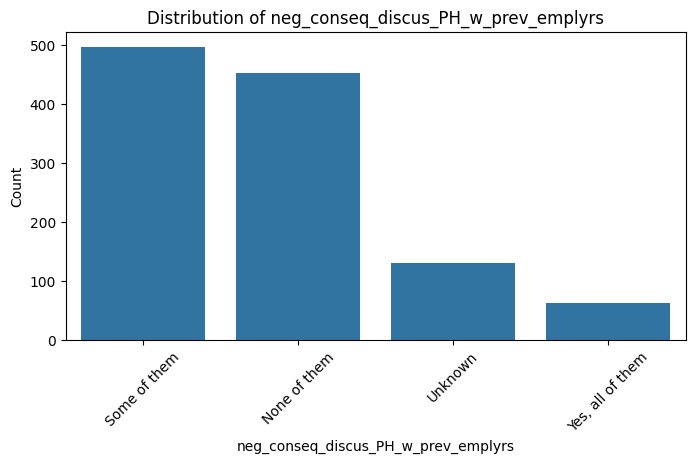

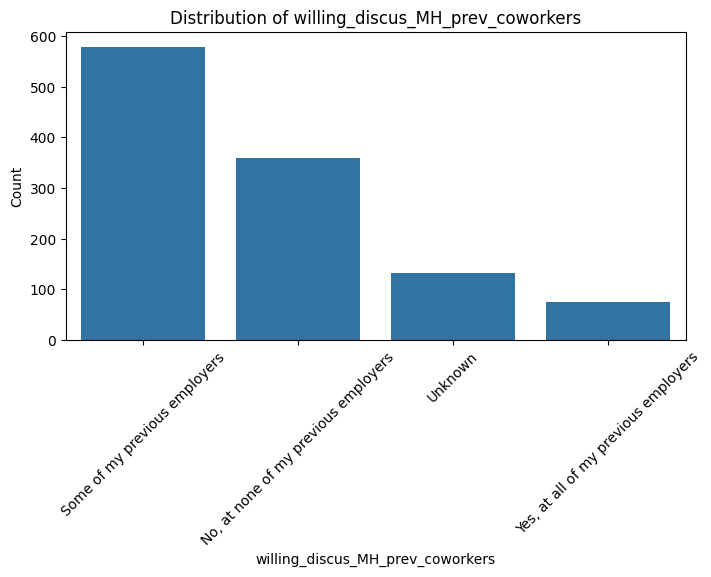

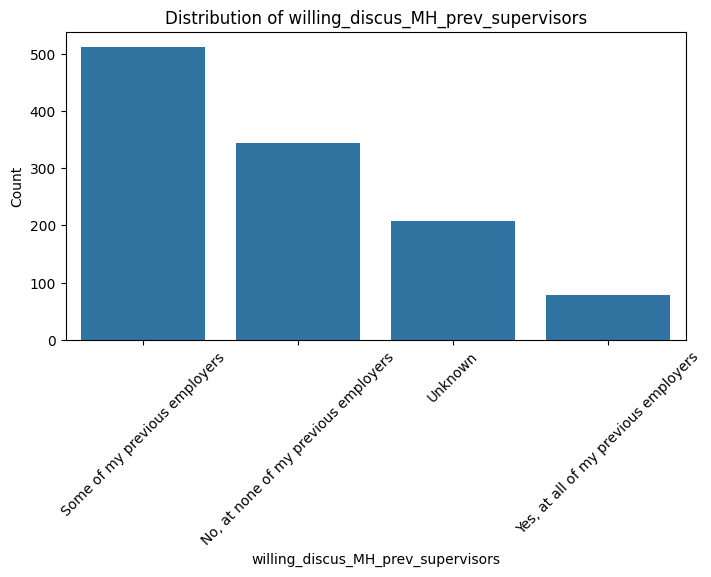

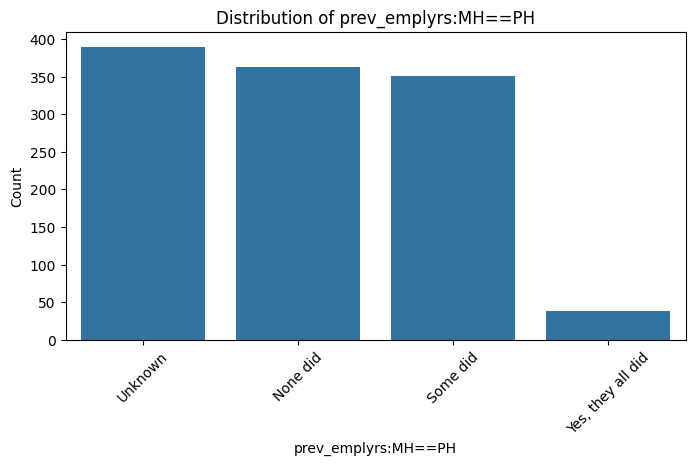

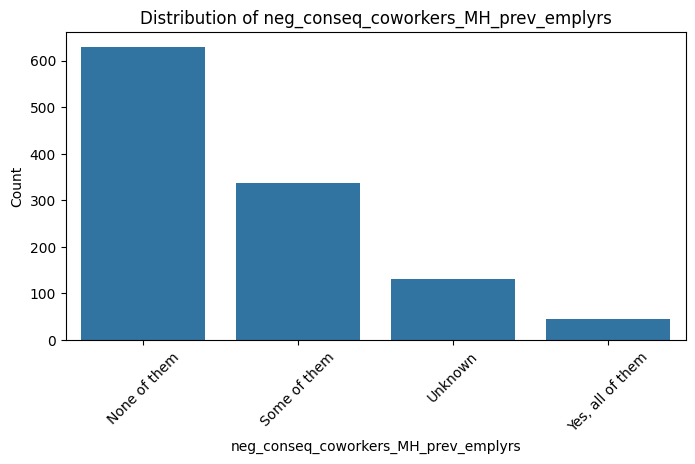

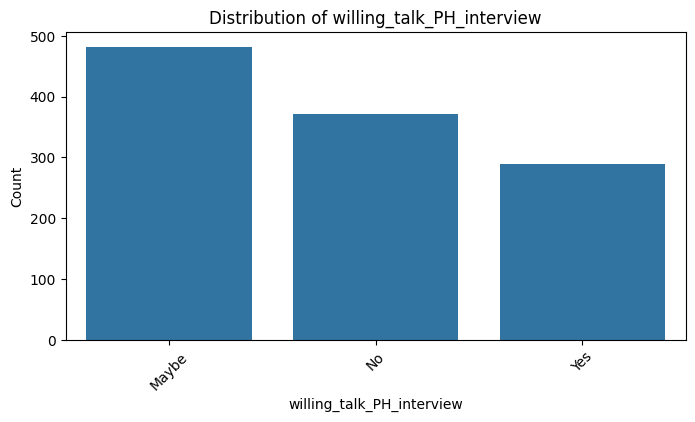

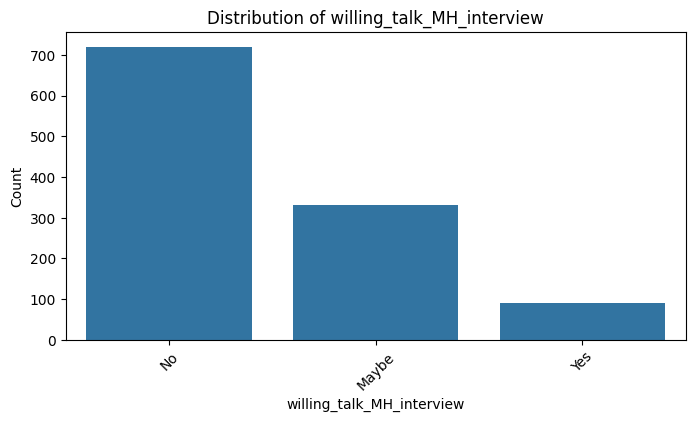

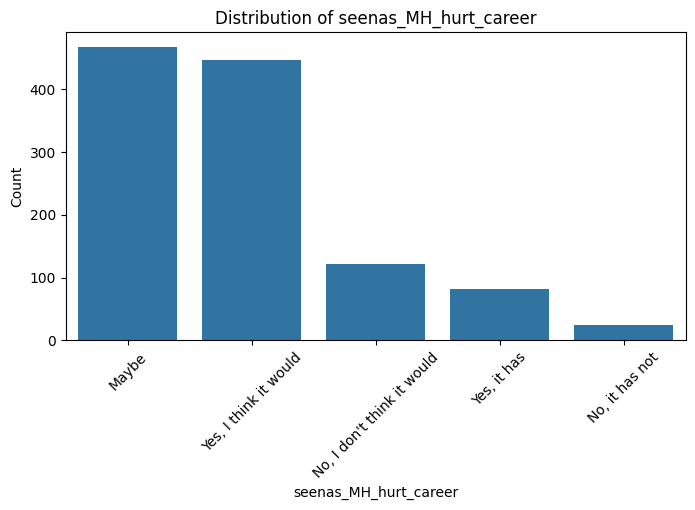

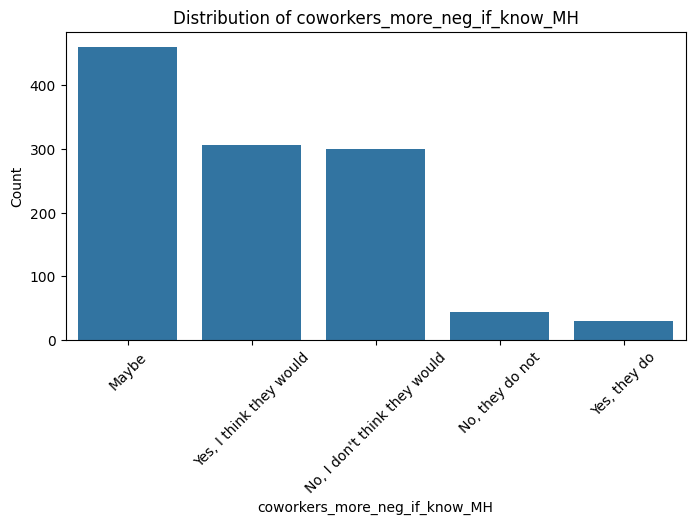

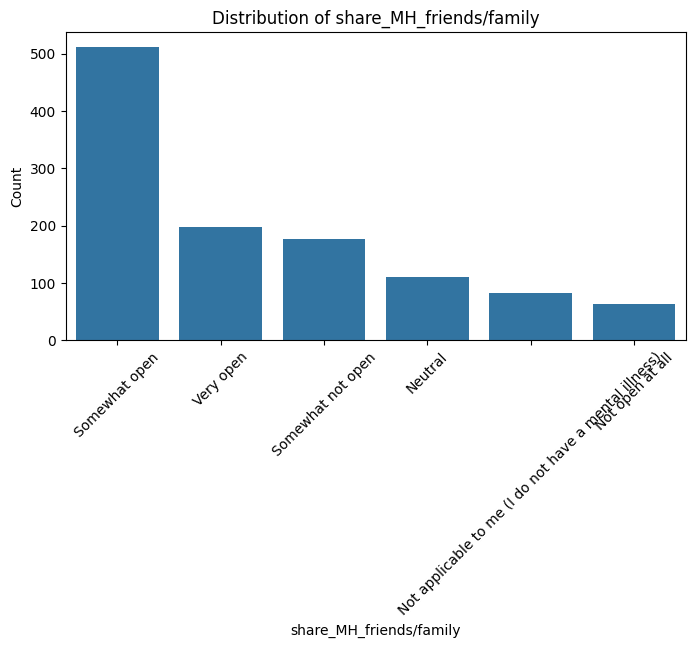

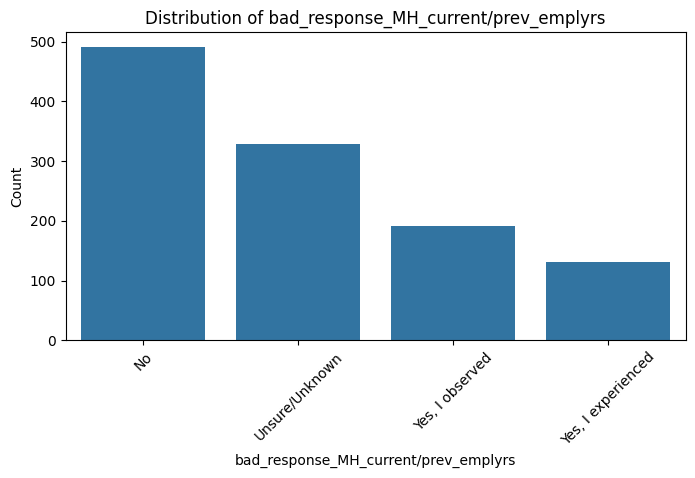

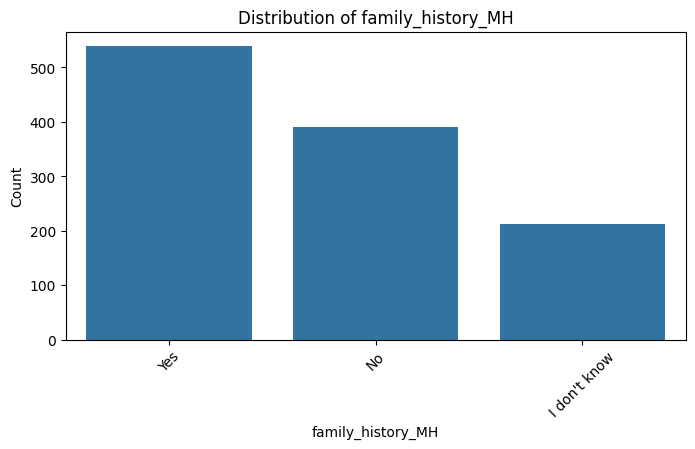

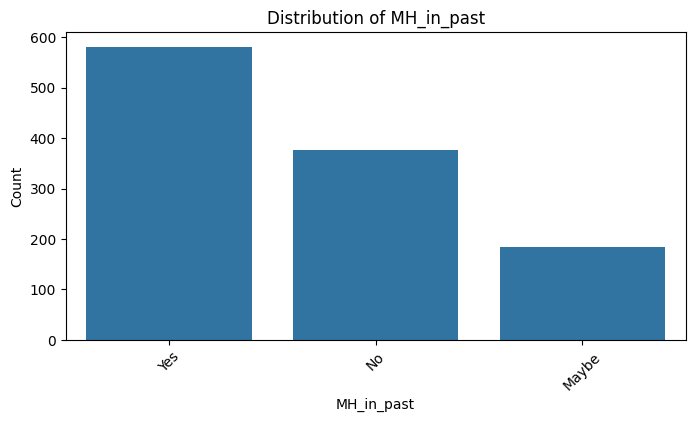

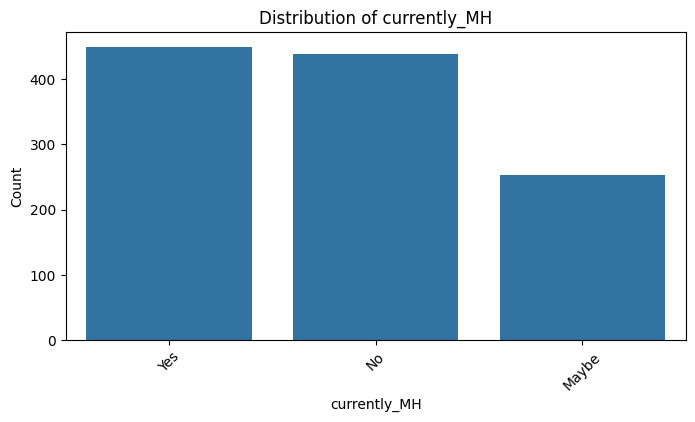

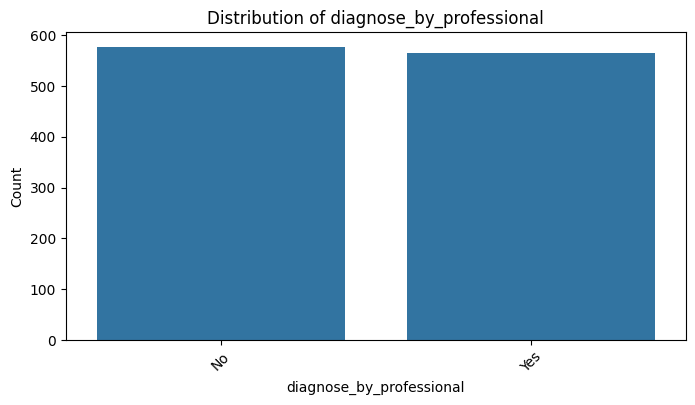

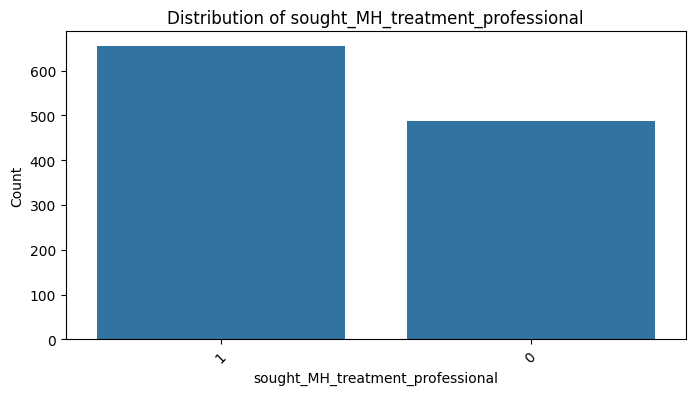

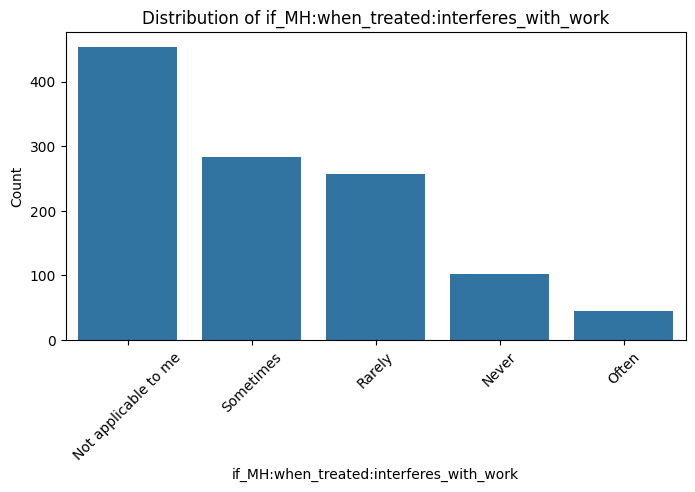

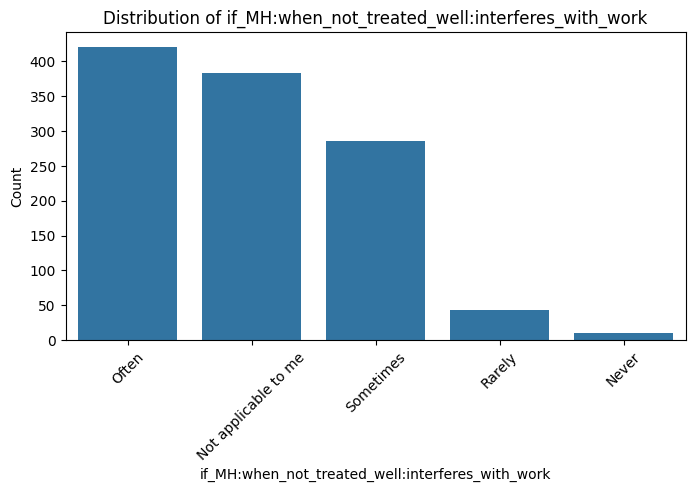

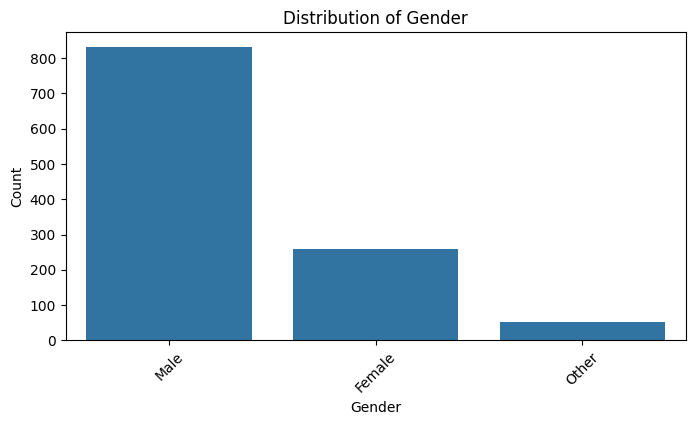

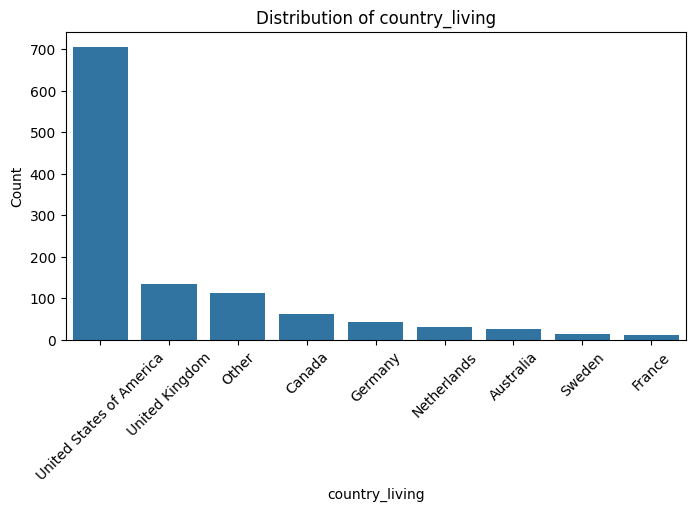

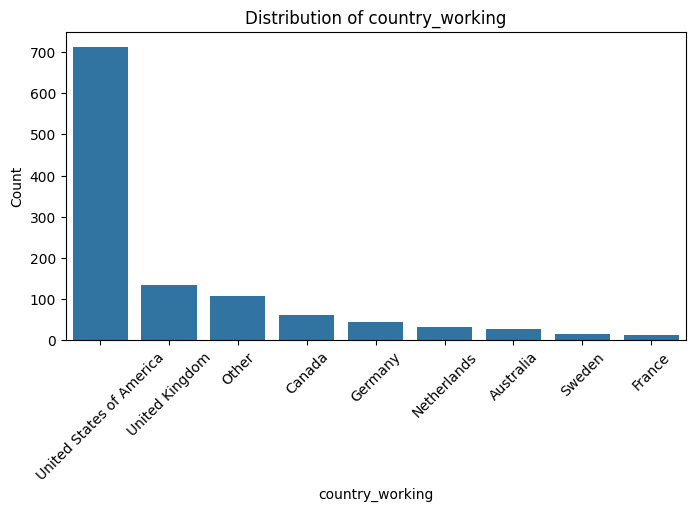

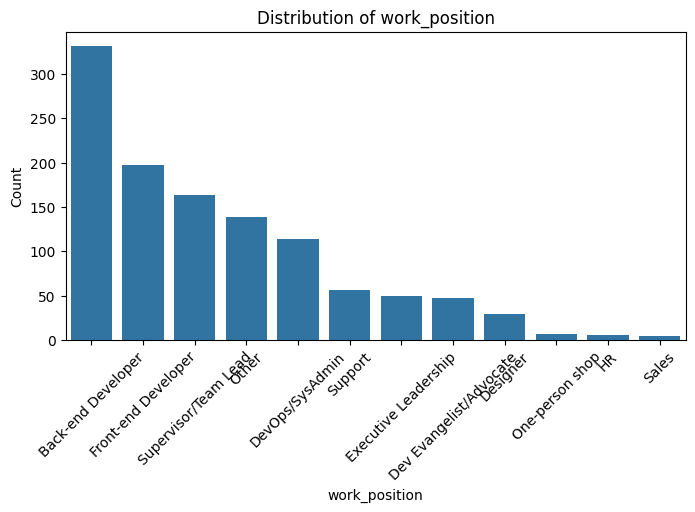

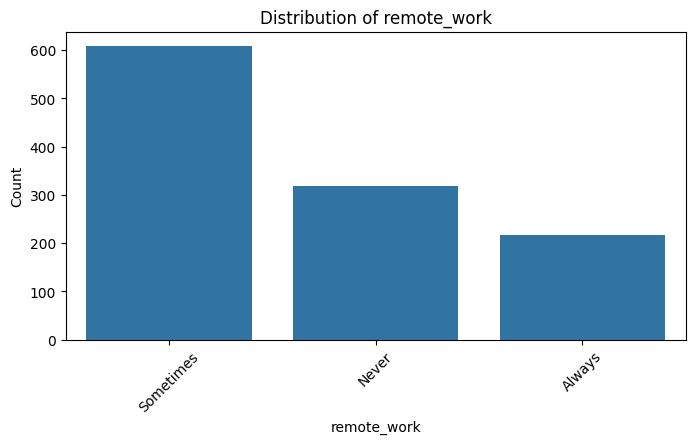

In [28]:
#dfr_cleaned.select_dtypes(['int','float'])
#dfr_cleaned.describe(include='all')

categorical_cols = dfr_cleaned.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=dfr_cleaned, x=col, order=dfr_cleaned[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
    plt.close()


## 3.4 Associations between features

In [29]:
def chi2_tests(dataframe, categ_cols):
    results = []
    for i, col1 in enumerate(categ_cols):
        for col2 in categ_cols[i+1:]:
            contingency_table = pd.crosstab(dataframe[col1], dataframe[col2])
            chi2, p, dof, expected = chi2_contingency(contingency_table)

            n = contingency_table.values.sum()
            r, k = contingency_table.shape

            cramers_v = cramers_v_bias_corrected(chi2, n, r, k)

            results.append({'Column1': col1, 'Column2': col2,
                            'Chi2': chi2, 'p-value': p, 'DoF': dof,
                            'CramersV': cramers_v,
                            })
            results.append({'Column1': col2, 'Column2': col1,
                            'Chi2': chi2, 'p-value': p, 'DoF': dof,
                            'CramersV': cramers_v,
                            })

    return pd.DataFrame(results)

def cramers_v_bias_corrected(chi2, n, r, k):
    """
    n: total sample size, r: No of rows in the contingency table, k: No of cols
    """
    phi2 = chi2 / n
    # Bias correction, see https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V#Bias_correction
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min(kcorr - 1, rcorr - 1))

                            Column1                        Column2  \
0                       n_employees               employer_is_tech   
1                  employer_is_tech                    n_employees   
2                       n_employees  employer_provides_HC-benefits   
3     employer_provides_HC-benefits                    n_employees   
4                       n_employees          employer_discussed_MH   
...                             ...                            ...   
1715                    remote_work                 country_living   
1718                country_working                    remote_work   
1719                    remote_work                country_working   
1720                  work_position                    remote_work   
1721                    remote_work                  work_position   

            Chi2       p-value  DoF  CramersV  
0     116.994174  1.358911e-23    5  0.313290  
1     116.994174  1.358911e-23    5  0.313290  
2     142.78664

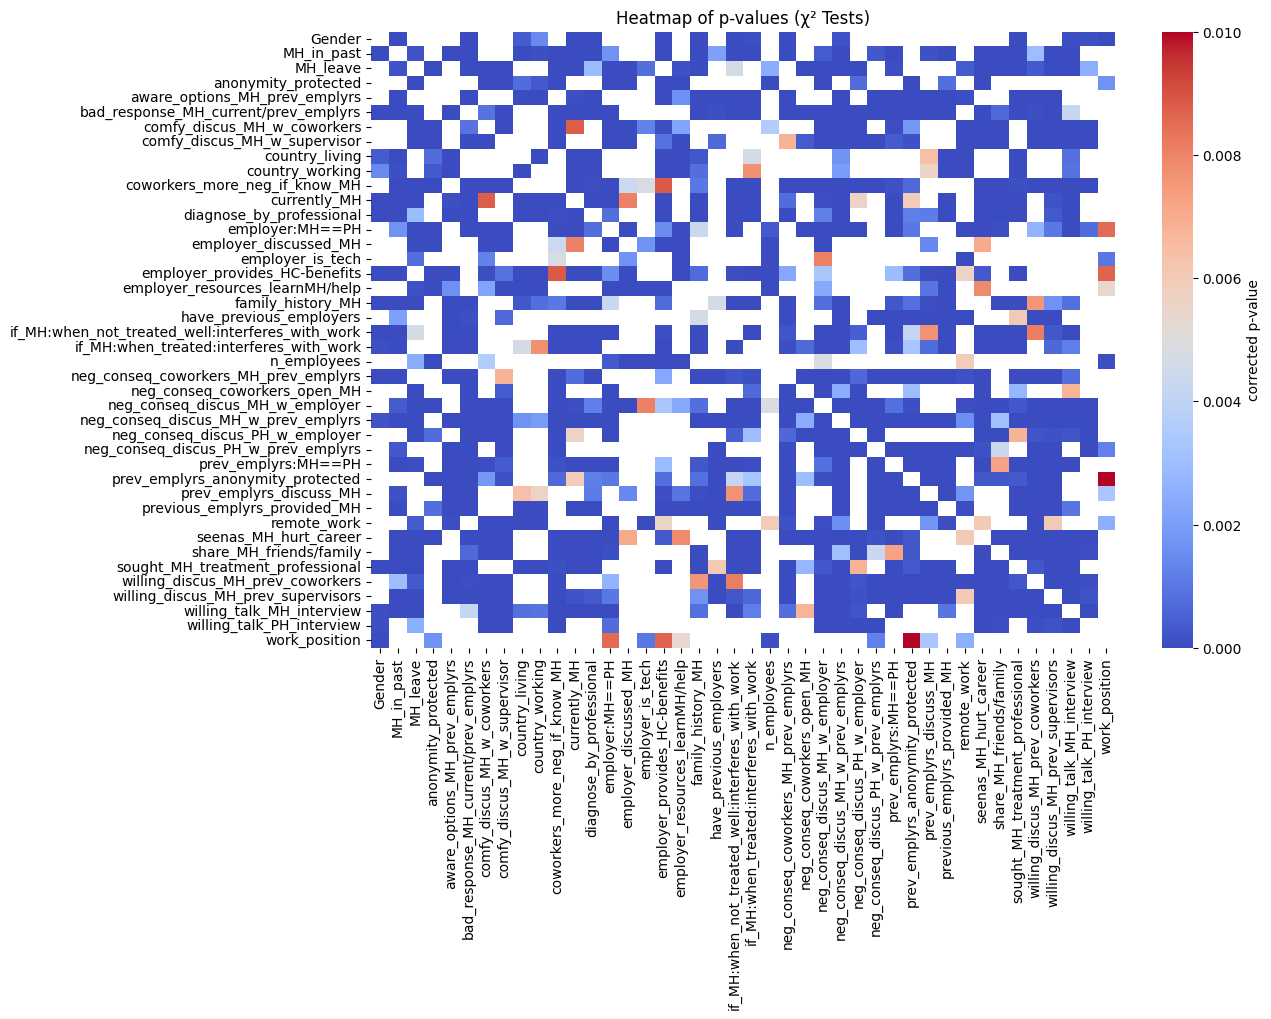

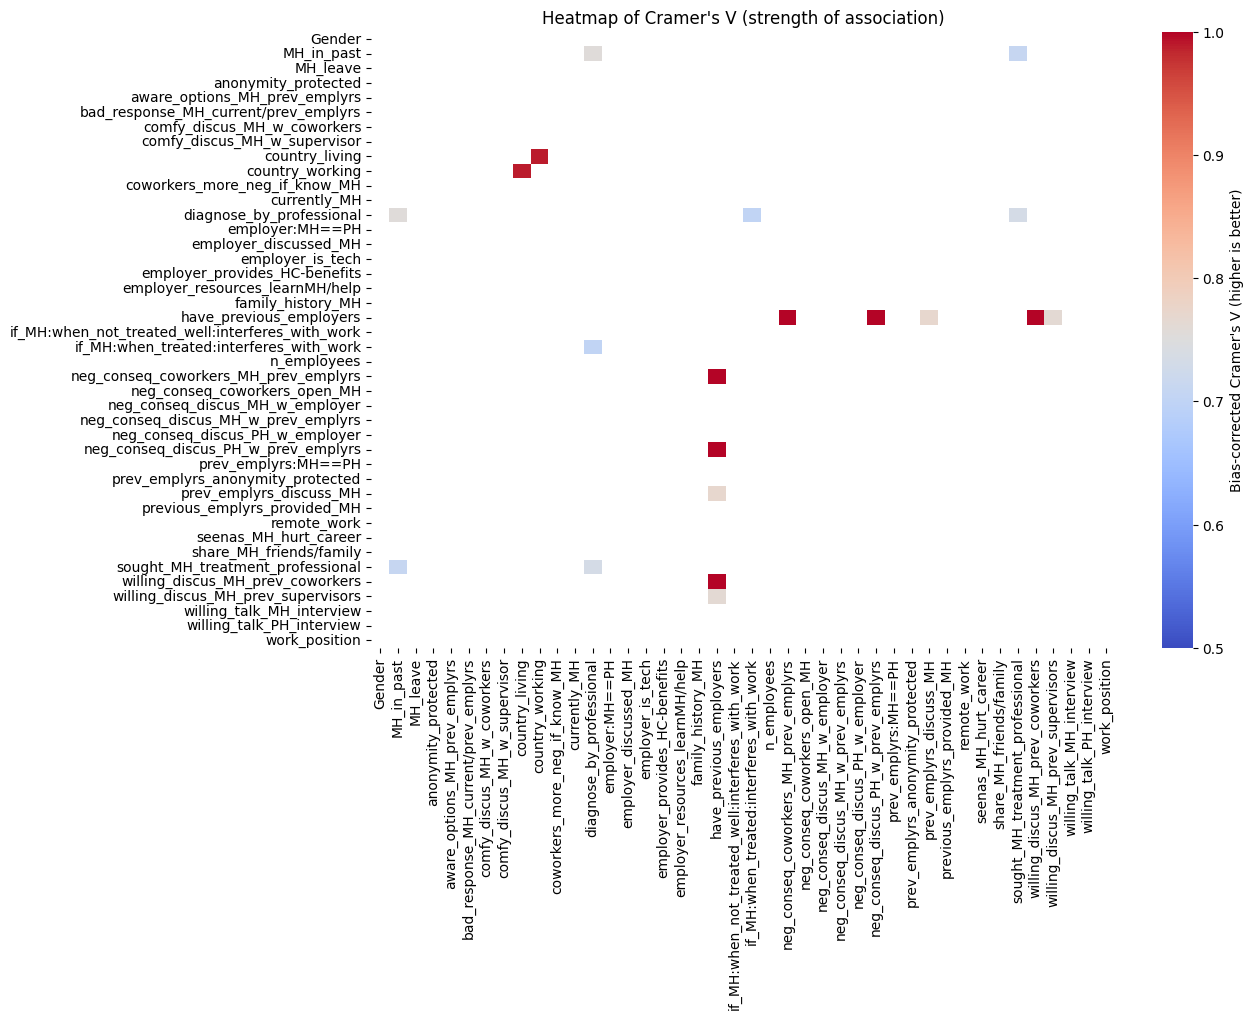

In [30]:
categorical_cols = dfr_cleaned.columns.drop("Age")

chi2_results = chi2_tests(dfr_cleaned, categorical_cols)
#print(chi2_results)

significance = 0.01
#significant_results = chi2_results[chi2_results['p-value'] < 0.01].sort_values(by='p-value', ascending=False)
significant_results = chi2_results[chi2_results['p-value'] < significance]
print(significant_results)

chi2_results['p_corrected'] = multipletests(chi2_results['p-value'], method='fdr_bh')[1]
significant_results_corrected = chi2_results[chi2_results['p_corrected'] < significance].sort_values(by='p_corrected', ascending=False)
#print(significant_results_corrected)

# with alpha <= 0.01
# - no FWER/FDR corrections: 519 associations remain
# - Benjamini-Hochberg (FDR): 495 associations remain
# - Bonferroni correction: 316 associations remain

# There are 42 categorical columns, so the total number of 2-col comparisons is
# 861 = 42_C_2 = 42!/(40!2!)



# ##############################################################################
# χ²: just p-values
# ##############################################################################

heatmap_data = chi2_results.pivot(index='Column1',columns='Column2', values='p_corrected')
heatmap_data_symmetrical = np.maximum(heatmap_data, heatmap_data.T) 
mask = heatmap_data_symmetrical >= significance
print("Symmetrical heatmap data:\n", heatmap_data_symmetrical)

# note: this chart shows the (corrected) p-values.
# χ² test of independence:: Null: no association, Alternate: ∃ association
# I.e. whether or not there is an association
# The magnitude (i.e, is there an actual practical meaning), is not seen here

plt.figure(figsize=(12, 8))
#sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'corrected p-value'}, mask=mask,vmin=0, vmax=0.01)
sns.heatmap(heatmap_data_symmetrical, cmap='coolwarm',
             cbar_kws = {'label': 'corrected p-value'},
             mask = mask,
             vmin = 0,
             vmax = significance)
plt.title("Heatmap of p-values (χ² Tests)")
plt.savefig("final-heatmap_X2.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

# ##############################################################################
# Cramer's V: magnitude of association
# ##############################################################################
heatmap_data_v = chi2_results.pivot(index='Column1', columns='Column2', values='CramersV')
heatmap_data_v_symmetrical = np.maximum(heatmap_data_v, heatmap_data_v.T)
mask_v = heatmap_data_v_symmetrical < 0.7

plt.figure(
    #figsize=(6, 4)
    figsize=(12, 8)
    )
sns.heatmap(heatmap_data_v_symmetrical, cmap='coolwarm',
            cbar_kws={'label': "Bias-corrected Cramer's V (higher is better)"},
            vmin=0.5,
            vmax=1,
            mask = mask_v)
plt.title("Heatmap of Cramer's V (strength of association)")
plt.savefig("final-heatmap_cramer.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

In [31]:
print(new_old_colnames['have_previous_employers'])
print(new_old_colnames['neg_conseq_coworkers_MH_prev_emplyrs'])
print(new_old_colnames['neg_conseq_discus_MH_w_prev_emplyrs'])
print(new_old_colnames['prev_emplyrs_discuss_MH'])
print(new_old_colnames['willing_discus_MH_prev_coworkers'])
print(new_old_colnames['willing_discus_MH_prev_supervisors'])

Do you have previous employers?
Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?
Do you think that discussing a mental health disorder with previous employers would have negative consequences?
Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?
Would you have been willing to discuss a mental health issue with your previous co-workers?
Would you have been willing to discuss a mental health issue with your direct supervisor(s)?


Note:
- the strong association between country_living & country_working (to be expected)
- strong association between 'have_previous_employers" ("Do you have previous employers?) and
  - neg_conseq_coworkers_MH_prev_emplyrs ("Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?)
  - neg_conseq_discus_MH_w_prev_emplyrs ("Do you think that discussing a mental health disorder with previous employers would have negative consequences?")
  - prev_emplyrs_discuss_MH ("Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?")
  - willing_discus_MH_prev_coworkers ("Would you have been willing to discuss a mental health issue with your previous co-workers?")
  - willing_discus_MH_prev_supervisors ("Would you have been willing to discuss a mental health issue with your direct supervisor(s)?")
which is also to be expected, as these questions imply having a previous employer.

This also means we are able to drop more features. If 2 features are highly associated, we will drop 1 of them. 
(Keep in mind, we have only kept associations where the (FDR-adjusted) p-value < 0.01)

As a treshold, we will take a magnitude (Cramer's V) of 0.6, and drop 1 of pairwise features with a higher association.

## 3.5 Drop further features

In [32]:
# note, this all came about because the the clustering metrics are not very good on the 1st pass
# this is our 2nd pass

droplist = [
    "country_living",
    "diagnose_by_professional",
    "sought_MH_treatment_professional",
    "have_previous_employers",
    "willing_discus_MH_prev_coworkers",
    ]

for col in droplist:
    if col in dfr_cleaned.columns:
        dfr_cleaned = dfr_cleaned.drop(col, axis=1)    


# 4) Feature Engineering, Extraction, Selection

## 4.1 Encode categoricals

In [33]:
print("Shape of dfr_cleaned:", dfr_cleaned.shape)
# 1st pass: 43 columns
# 2nd pass: 38 columns

X_dummies = pd.get_dummies(dfr_cleaned, drop_first=True)
# ↑ to remember: numericals are skipped automatically by Pandas
print("Shape after dummy encoding:", X_dummies.shape)
# 1st pass: from 43 columns to 130 columns
# 2nd pass: from 38 columns to 116 columns

feature_names = X_dummies.columns.tolist()

Shape of dfr_cleaned: (1142, 38)
Shape after dummy encoding: (1142, 116)


## 4.2 Scale features

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummies)

## 4.3 Dimensionality Reduction (PCA)

### 4.3.1 Determine values for variance explained-cutoff

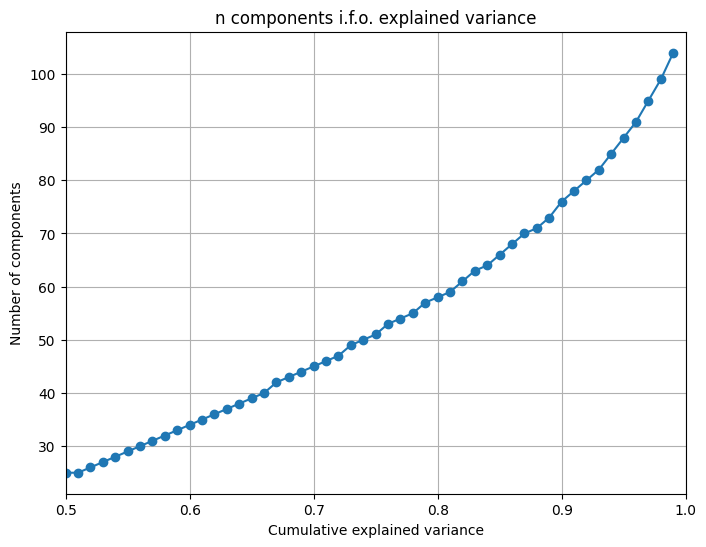

In [35]:
# How to choose n_components?
# 90% as convention, or better values?
# investigate if there is an elbow in the plot
# -> approx. linear until ca 0.7, then faster rise
# -> discovered nothing special, maintain default 0.9

from sklearn.decomposition import PCA

pca_full = PCA(n_components = 116) # 116 columns after dummy-encoding (2nd pass)
pca_full.fit(X_scaled)

cumulative_explained_variance = np.cumsum(pca_full.explained_variance_ratio_)
thresholds = np.linspace(0.5, 0.99, 50)
components_required = []

for t in thresholds:
    num_components = np.argmax(cumulative_explained_variance >= t) + 1
    components_required.append(num_components)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, components_required, marker='o')
plt.xlabel("Cumulative explained variance")
plt.ylabel("Number of components")
plt.title("n components i.f.o. explained variance")
plt.grid(True)
plt.xlim(0.5, 1.0) 
#plt.plot([0.5, 0.70], [22, 43], color='red', linestyle='--', linewidth=2, label="Straight Line")
plt.savefig("final-PCA-elbow.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()


### 4.3.2 Do PCA

In [36]:
# initially 130 columns (1st pass)
# components: 0.9 -> 76 cols (-42% cols)
# components: 0.8 -> 57 cols (-56% cols)
# components: 0.7 -> 43 cols (-76% cols)

pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

print("Shape after PCA:", X_pca.shape) # 76 cols (n_components = 0.9)
cumulative_variance = np.sum(pca.explained_variance_ratio_)
#print("Cumul Explained Variance:", round(cumulative_variance, 3))

loadings = pca.components_.T # n_features, n_components
n_components = pca.components_.shape[0]

for i in range(n_components):
    explained_var = pca.explained_variance_ratio_[i]
    print(f"\nComponent {i+1} (Explained Variance Ratio: {explained_var:.3f})")
    comp_loadings = loadings[:, i]
    sorted_indices = np.argsort(np.abs(comp_loadings))[::-1]
    top_features = [(feature_names[idx], comp_loadings[idx]) for idx in sorted_indices[:5]]
    
    print("Top 5 features (with loadings):")
    for feat, val in top_features:
        print(f"\t{feat}: {val:.3f}")


Shape after PCA: (1142, 76)

Component 1 (Explained Variance Ratio: 0.070)
Top 5 features (with loadings):
	if_MH:when_not_treated_well:interferes_with_work_Not applicable to me: 0.224
	if_MH:when_treated:interferes_with_work_Not applicable to me: 0.217
	MH_in_past_Yes: -0.216
	MH_in_past_No: 0.216
	previous_emplyrs_provided_MH_Unknown: 0.214

Component 2 (Explained Variance Ratio: 0.060)
Top 5 features (with loadings):
	neg_conseq_discus_MH_w_employer_No: 0.253
	comfy_discus_MH_w_supervisor_Yes: 0.243
	comfy_discus_MH_w_supervisor_No: -0.238
	comfy_discus_MH_w_coworkers_No: -0.223
	neg_conseq_discus_MH_w_employer_Yes: -0.219

Component 3 (Explained Variance Ratio: 0.041)
Top 5 features (with loadings):
	neg_conseq_coworkers_MH_prev_emplyrs_Unknown: 0.252
	neg_conseq_discus_PH_w_prev_emplyrs_Unknown: 0.252
	if_MH:when_treated:interferes_with_work_Not applicable to me: -0.246
	if_MH:when_not_treated_well:interferes_with_work_Not applicable to me: -0.242
	prev_emplyrs_discuss_MH_Unknown:

# 5) Clustering (k-Means)

## 5.1 determination of k-value

In [ ]:
# runtime is ca 6 min for n = 100!
# runtime is ca 35s for n = 10 
# mean results are stored in the next cell, for convenience

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

K_range = range(2, 21)
#n_iterations = 1_000
n_iterations = 100

inertia_dict = {k: [] for k in K_range}
silhouette_dict = {k: [] for k in K_range}
db_dict = {k: [] for k in K_range}

for i in range(n_iterations):
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=None, n_init=20)
        labels = kmeans.fit_predict(X_pca)
        inertia_dict[k].append(kmeans.inertia_)
        silhouette_dict[k].append(silhouette_score(X_pca, labels))
        db_dict[k].append(davies_bouldin_score(X_pca, labels))

avg_inertia = {k: np.mean(inertia_dict[k]) for k in K_range}
avg_silhouette = {k: np.mean(silhouette_dict[k]) for k in K_range}
avg_db = {k: np.mean(db_dict[k]) for k in K_range}

print(f"{avg_inertia=}")
print(f"{avg_silhouette=}")
print(f"{avg_db=}", "\n")

#print(f"{inertia_dict=}")
#print(f"{silhouette_dict=}")
#print(f"{db_dict=}")

avg_inertia={2: np.float64(113138.128246792), 3: np.float64(108546.09267749246), 4: np.float64(105178.95601839694), 5: np.float64(103351.55176575562), 6: np.float64(101839.17167520006), 7: np.float64(100567.54418160887), 8: np.float64(99450.13020884135), 9: np.float64(98391.29932336873), 10: np.float64(97437.60304295091), 11: np.float64(96571.13948804821), 12: np.float64(95717.95666232725), 13: np.float64(94837.88722218879), 14: np.float64(94099.3286511582), 15: np.float64(93330.72508040765), 16: np.float64(92612.18490239652), 17: np.float64(91888.36757447122), 18: np.float64(91196.82516406669), 19: np.float64(90564.08827752944), 20: np.float64(89877.60093191681)}
avg_silhouette={2: np.float64(0.05521756632764428), 3: np.float64(0.0551555895077149), 4: np.float64(0.054650223613171914), 5: np.float64(0.04431658724757479), 6: np.float64(0.03566070214151459), 7: np.float64(0.03690023942958445), 8: np.float64(0.03707838793861623), 9: np.float64(0.03693943559056742), 10: np.float64(0.036169

In [ ]:
""" # results of n_iterations = 100
avg_inertia={2: np.float64(113138.128246792), 3: np.float64(108546.09267749246), 4: np.float64(105178.95601839694), 5: np.float64(103351.55176575562), 6: np.float64(101839.17167520006), 7: np.float64(100567.54418160887), 8: np.float64(99450.13020884135), 9: np.float64(98391.29932336873), 10: np.float64(97437.60304295091), 11: np.float64(96571.13948804821), 12: np.float64(95717.95666232725), 13: np.float64(94837.88722218879), 14: np.float64(94099.3286511582), 15: np.float64(93330.72508040765), 16: np.float64(92612.18490239652), 17: np.float64(91888.36757447122), 18: np.float64(91196.82516406669), 19: np.float64(90564.08827752944), 20: np.float64(89877.60093191681)}
avg_silhouette={2: np.float64(0.05521756632764428), 3: np.float64(0.0551555895077149), 4: np.float64(0.054650223613171914), 5: np.float64(0.04431658724757479), 6: np.float64(0.03566070214151459), 7: np.float64(0.03690023942958445), 8: np.float64(0.03707838793861623), 9: np.float64(0.03693943559056742), 10: np.float64(0.036169291314884375), 11: np.float64(0.03575896768368462), 12: np.float64(0.03480157740327614), 13: np.float64(0.03522312471753135), 14: np.float64(0.03393734351668068), 15: np.float64(0.03345961688291103), 16: np.float64(0.03252440444489263), 17: np.float64(0.032296237057198106), 18: np.float64(0.032340479761378355), 19: np.float64(0.031823608385936696), 20: np.float64(0.031562007934295346)}
avg_db={2: np.float64(4.018028499727225), 3: np.float64(3.5407052609860465), 4: np.float64(3.6118081666642454), 5: np.float64(3.8209456506193447), 6: np.float64(3.912838946001305), 7: np.float64(3.792568836366869), 8: np.float64(3.6871087110053526), 9: np.float64(3.5994030809811517), 10: np.float64(3.541346011833064), 11: np.float64(3.5021135238476164), 12: np.float64(3.462346806397791), 13: np.float64(3.4025521080021317), 14: np.float64(3.3991947185419535), 15: np.float64(3.3524574985567357), 16: np.float64(3.345087021478698), 17: np.float64(3.311948986551657), 18: np.float64(3.2717698665261707), 19: np.float64(3.2514078092412286), 20: np.float64(3.2290470025120794)} 

"""

' results of n_iterations = 100\navg_inertia={2: np.float64(125852.59535774057), 3: np.float64(119060.7748973615), 4: np.float64(115724.13396906458), 5: np.float64(113654.78464312656), 6: np.float64(111790.96901147859), 7: np.float64(109961.62650241006), 8: np.float64(108346.60884415773), 9: np.float64(106786.45805617138), 10: np.float64(105159.84252835969), 11: np.float64(103645.55543057054), 12: np.float64(102308.88937608982), 13: np.float64(101047.14085685348), 14: np.float64(99710.82656638637), 15: np.float64(98418.5271089707), 16: np.float64(97352.45095624722), 17: np.float64(96297.9739038772), 18: np.float64(95331.75693644883), 19: np.float64(94487.68334648006), 20: np.float64(93751.23090058623)}\navg_silhouette={2: np.float64(0.09941702000221608), 3: np.float64(0.07041495730858845), 4: np.float64(0.061931705066495056), 5: np.float64(0.06356913315341003), 6: np.float64(0.05978980882595047), 7: np.float64(0.05687625695200147), 8: np.float64(0.052165032900106975), 9: np.float64(0.0

In [150]:
avg_silh_avg = 0
for key, val in avg_silhouette.items():
    avg_silh_avg += val
print(avg_silh_avg/len(avg_silhouette.keys()))

avg_db_avg = 0
for key, val in avg_db.items():
    avg_db_avg += val
print(avg_db_avg/len(avg_db.keys()))

0.03820081004731884
3.529088342412667


In [151]:
min_inertia = {k: min(inertia_dict[k]) for k in K_range}
max_inertia = {k: max(inertia_dict[k]) for k in K_range}

min_silhouette = {k: min(silhouette_dict[k]) for k in K_range}
max_silhouette = {k: max(silhouette_dict[k]) for k in K_range}

min_db = {k: min(db_dict[k]) for k in K_range}
max_db = {k: max(db_dict[k]) for k in K_range}

print("k \t min    \t mean    \t max    \t range \t (SILHOUETTE)")
for k in K_range:
    print(f"{k=}: \t {min_silhouette[k]:.4f} \t {avg_silhouette[k]:.4f} \t {max_silhouette[k]:.4f} \t {max_silhouette[k] - min_silhouette[k]:.4f}")

#db_dict


k 	 min    	 mean    	 max    	 range 	 (SILHOUETTE)
k=2: 	 0.0551 	 0.0552 	 0.0553 	 0.0002
k=3: 	 0.0549 	 0.0552 	 0.0554 	 0.0005
k=4: 	 0.0541 	 0.0547 	 0.0551 	 0.0010
k=5: 	 0.0400 	 0.0443 	 0.0497 	 0.0097
k=6: 	 0.0324 	 0.0357 	 0.0400 	 0.0076
k=7: 	 0.0320 	 0.0369 	 0.0430 	 0.0110
k=8: 	 0.0311 	 0.0371 	 0.0439 	 0.0128
k=9: 	 0.0278 	 0.0369 	 0.0433 	 0.0156
k=10: 	 0.0272 	 0.0362 	 0.0452 	 0.0180
k=11: 	 0.0279 	 0.0358 	 0.0462 	 0.0183
k=12: 	 0.0256 	 0.0348 	 0.0421 	 0.0165
k=13: 	 0.0245 	 0.0352 	 0.0451 	 0.0206
k=14: 	 0.0203 	 0.0339 	 0.0431 	 0.0228
k=15: 	 0.0234 	 0.0335 	 0.0475 	 0.0242
k=16: 	 0.0199 	 0.0325 	 0.0416 	 0.0217
k=17: 	 0.0207 	 0.0323 	 0.0418 	 0.0211
k=18: 	 0.0236 	 0.0323 	 0.0401 	 0.0165
k=19: 	 0.0240 	 0.0318 	 0.0400 	 0.0160
k=20: 	 0.0225 	 0.0316 	 0.0390 	 0.0165


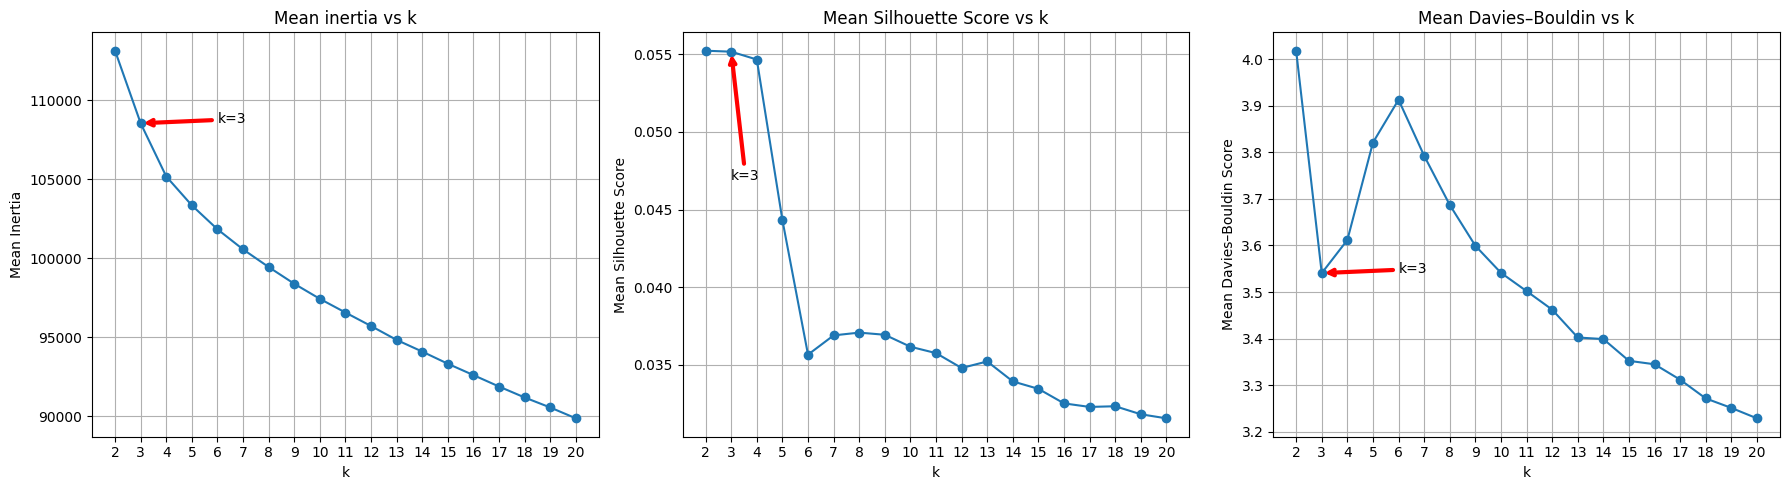

In [152]:
### Large size plot

from matplotlib.ticker import FixedLocator

inertia_vals = [avg_inertia[k] for k in K_range]
silhouette_vals = [avg_silhouette[k] for k in K_range]
db_vals = [avg_db[k] for k in K_range]
k_choice = 3

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# inertia
axes[0].plot(K_range, inertia_vals, marker='o')
axes[0].set_title("Mean inertia vs k")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Mean Inertia")
axes[0].grid(True)
axes[0].xaxis.set_major_locator(FixedLocator(K_range))
idx = K_range.index(k_choice)
axes[0].annotate(f"k={k_choice}", 
            xy=(k_choice, inertia_vals[idx]),
            xytext=(k_choice+3, inertia_vals[idx]),
            arrowprops=dict(arrowstyle='->', color='red', lw=3))

# silhouette
axes[1].plot(K_range, silhouette_vals, marker='o')
axes[1].set_title("Mean Silhouette Score vs k")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Mean Silhouette Score")
axes[1].grid(True)
axes[1].xaxis.set_major_locator(FixedLocator(K_range))
idx = K_range.index(k_choice)
axes[1].annotate(f"k={k_choice}", 
            xy=(k_choice, silhouette_vals[idx]),
            xytext=(k_choice+0, silhouette_vals[idx] * 0.85),
            arrowprops=dict(arrowstyle='->', color='red', lw=3))

# DB
axes[2].plot(K_range, db_vals, marker='o')
axes[2].set_title("Mean Davies–Bouldin vs k")
axes[2].set_xlabel("k")
axes[2].set_ylabel("Mean Davies–Bouldin Score")
axes[2].grid(True)
axes[2].xaxis.set_major_locator(FixedLocator(K_range))
idx = K_range.index(k_choice)
axes[2].annotate(f"k={k_choice}", 
            xy=(k_choice, db_vals[idx]),
            xytext=(k_choice+3, db_vals[idx] * 1),
            arrowprops=dict(arrowstyle='->', color='red', lw=3))

plt.tight_layout()
plt.savefig("final-optimal-k-large.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()


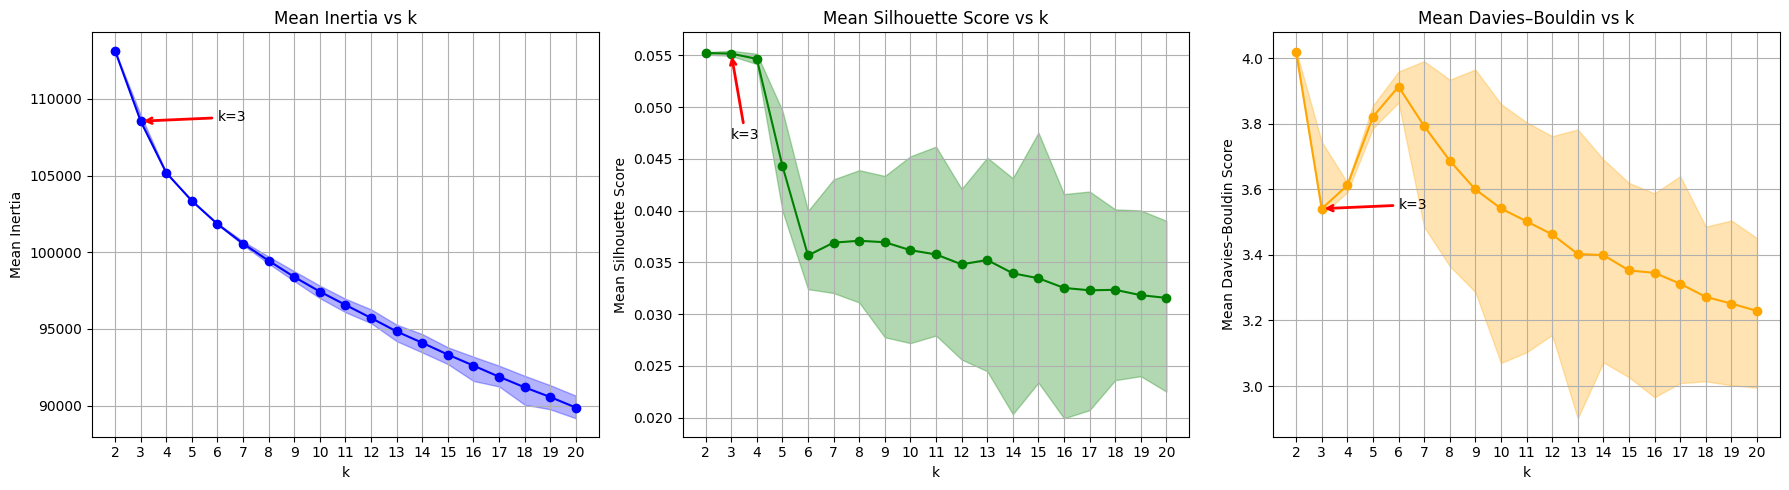

In [153]:
inertia_vals      = [avg_inertia[k] for k in K_range]
inertia_lower     = [min_inertia[k] for k in K_range]
inertia_upper     = [max_inertia[k] for k in K_range]

silhouette_vals   = [avg_silhouette[k] for k in K_range]
silhouette_lower  = [min_silhouette[k] for k in K_range]
silhouette_upper  = [max_silhouette[k] for k in K_range]

db_vals           = [avg_db[k] for k in K_range]
db_lower          = [min_db[k] for k in K_range]
db_upper          = [max_db[k] for k in K_range]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(K_range, inertia_vals, marker='o', color='blue', label="Mean Inertia")
axes[0].fill_between(K_range, inertia_lower, inertia_upper, color='blue', alpha=0.3, label="Range")
axes[0].set_title("Mean Inertia vs k")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Mean Inertia")
axes[0].grid(True)
axes[0].xaxis.set_major_locator(FixedLocator(K_range))

idx = K_range.index(3)
axes[0].annotate('k=3', 
                 xy=(3, inertia_vals[idx]),
                 xytext=(3+3, inertia_vals[idx]),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2))

axes[1].plot(K_range, silhouette_vals, marker='o', color='green', label="Mean Silhouette Score")
axes[1].fill_between(K_range, silhouette_lower, silhouette_upper, color='green', alpha=0.3, label="Range")
axes[1].set_title("Mean Silhouette Score vs k")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Mean Silhouette Score")
axes[1].grid(True)
axes[1].xaxis.set_major_locator(FixedLocator(K_range))
idx = K_range.index(3)
axes[1].annotate('k=3', 
                 xy=(3, silhouette_vals[idx]),
                 xytext=(3+0, silhouette_vals[idx] * 0.85),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2))

axes[2].plot(K_range, db_vals, marker='o', color='orange', label="Mean Davies–Bouldin Score")
axes[2].fill_between(K_range, db_lower, db_upper, color='orange', alpha=0.3, label="Range")
axes[2].set_title("Mean Davies–Bouldin vs k")
axes[2].set_xlabel("k")
axes[2].set_ylabel("Mean Davies–Bouldin Score")
axes[2].grid(True)
axes[2].xaxis.set_major_locator(FixedLocator(K_range))
idx = K_range.index(3)
axes[2].annotate('k=3', 
                 xy=(3, db_vals[idx]),
                 xytext=(3+3, db_vals[idx] * 1),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2))

plt.tight_layout()
plt.savefig("final-optimal-k-large-PCA-banded.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()


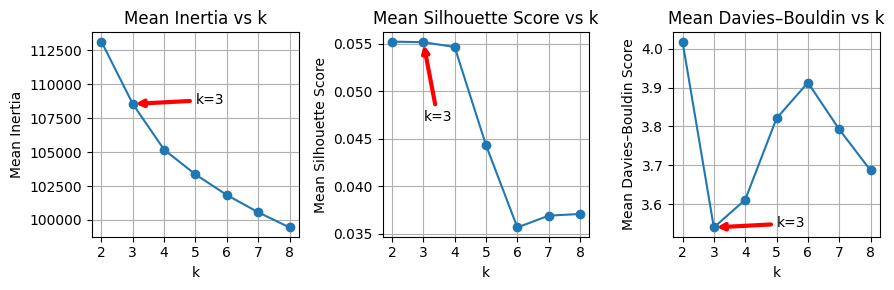

In [154]:
### Compact size plot

k_values = list(range(2, 9))
inertia_vals = [avg_inertia[k] for k in k_values]
silhouette_vals = [avg_silhouette[k] for k in k_values]
db_vals = [avg_db[k] for k in k_values]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].plot(k_values, inertia_vals, marker='o')
axes[0].set_title("Mean Inertia vs k")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Mean Inertia")
axes[0].grid(True)
axes[0].xaxis.set_major_locator(FixedLocator(k_values))
idx = k_values.index(3)
axes[0].annotate('k=3', 
            xy=(3, inertia_vals[idx]),
            xytext=(3+2, inertia_vals[idx]),
            arrowprops=dict(arrowstyle='->', color='red', lw=3))

axes[1].plot(k_values, silhouette_vals, marker='o')
axes[1].set_title("Mean Silhouette Score vs k")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Mean Silhouette Score")
axes[1].grid(True)
axes[1].xaxis.set_major_locator(FixedLocator(k_values))
idx = k_values.index(3)
axes[1].annotate('k=3', 
            xy=(3, silhouette_vals[idx]),
            xytext=(3+0, silhouette_vals[idx] * 0.85),
            arrowprops=dict(arrowstyle='->', color='red', lw=3))

axes[2].plot(k_values, db_vals, marker='o')
axes[2].set_title("Mean Davies–Bouldin vs k")
axes[2].set_xlabel("k")
axes[2].set_ylabel("Mean Davies–Bouldin Score")
axes[2].grid(True)
axes[2].xaxis.set_major_locator(FixedLocator(k_values))
idx = k_values.index(3)
axes[2].annotate('k=3', 
            xy=(3, db_vals[idx]),
            xytext=(3+2, db_vals[idx] * 1),
            arrowprops=dict(arrowstyle='->', color='red', lw=3))

plt.tight_layout()
plt.savefig("final-optimal-k-small-PCA.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

## 5.2 Clustering

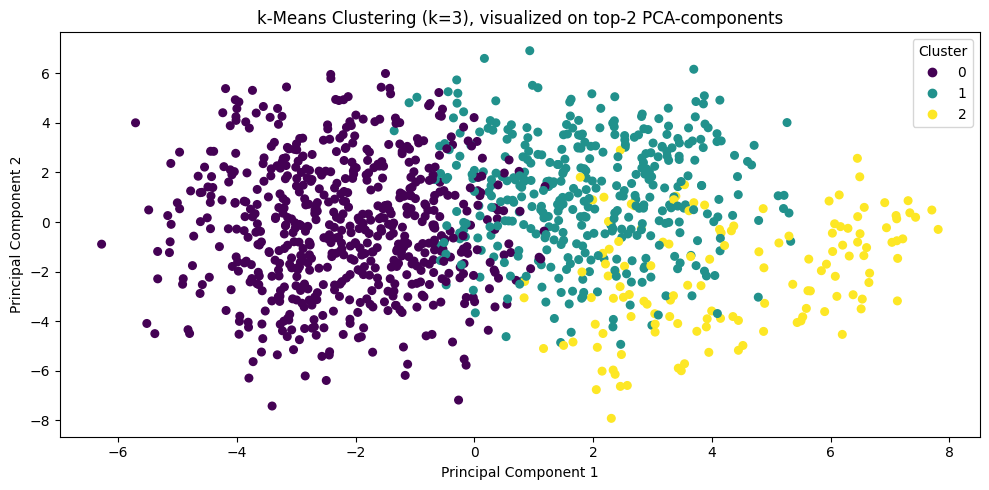

In [162]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=None, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

plt.figure(figsize=(10, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=30)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("k-Means Clustering (k=3), visualized on top-2 PCA-components")
handles, legnd_labels = scatter.legend_elements()
plt.legend(handles, legnd_labels, title="Cluster")
plt.tight_layout()
plt.savefig("final-clustering.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()


# 6) Evaluation of clusters

In [163]:
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
print("Cluster centroids (PCA'd):")
print(centroid_df)
print("#"*79)
# ##############################################################################
data_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
data_df["cluster"] = cluster_labels

cluster_means = data_df.groupby("cluster").mean()
print("mean PCA comp vals per cluster:")
print(cluster_means)


Cluster centroids (PCA'd):
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.171996 -0.207605  0.414580 -0.184777 -0.072754 -0.044493  0.064404   
1  1.891111  1.043367 -1.771200  0.067714  0.116578 -0.140807 -0.152179   
2  4.343226 -2.102404  3.286778  0.641399 -0.009877  0.612978  0.151692   

        PC8       PC9      PC10  ...      PC67      PC68      PC69      PC70  \
0 -0.133813  0.015452  0.027107  ...  0.021147  0.024880 -0.004229 -0.009060   
1 -0.208164  0.105108 -0.043977  ...  0.005643 -0.037168 -0.016092  0.007586   
2  1.215139 -0.376921  0.005260  ... -0.112489 -0.004501  0.066166  0.019001   

       PC71      PC72      PC73      PC74      PC75      PC76  
0 -0.002451  0.007167 -0.005705  0.016066  0.005688  0.006730  
1  0.012475 -0.003249  0.039067  0.005762 -0.014145 -0.000335  
2 -0.025277 -0.023060 -0.088111 -0.089770  0.015455 -0.029581  

[3 rows x 76 columns]
########################################################################

In [165]:
# the reason these are slightly different is because the first is using
# the PCA'd data, and inverse transforms it back again.
# however, because of the 90% cutoff, it's not identical anymore

centroids_pca = kmeans.cluster_centers_
centroids_original = pca.inverse_transform(centroids_pca)

centroids_df = pd.DataFrame(centroids_original, columns=feature_names)
print("Cluster centroids with original features:")
print(centroids_df)
print("#"*79)
# ##############################################################################
df_data = pd.DataFrame(X_scaled, columns=feature_names)
df_data['cluster'] = cluster_labels

cluster_summary = df_data.groupby('cluster').mean()
print("mean values per cluster:")
print(cluster_summary)

Cluster centroids with original features:
        Age  n_employees_100-500  n_employees_26-100  n_employees_500-1000  \
0  0.105569             0.065356           -0.007903             -0.017355   
1  0.002130            -0.054515            0.027380              0.051648   
2 -0.485578            -0.137663           -0.044022             -0.071932   

   n_employees_6-25  n_employees_More than 1000  employer_is_tech_1  \
0         -0.047889                    0.008677            0.038026   
1          0.074135                   -0.073172           -0.033911   
2          0.001088                    0.174155           -0.073695   

   employer_provides_HC-benefits_No  \
0                         -0.051855   
1                          0.052341   
2                          0.082701   

   employer_provides_HC-benefits_Not eligible for coverage / N/A  \
0                                           -0.03748               
1                                           -0.00144               

Top 10 features (with exclusions): ['MH_in_past_Yes', 'currently_MH_No', 'willing_discus_MH_prev_supervisors_Some of my previous employers', 'neg_conseq_discus_MH_w_prev_emplyrs_Some of them', 'if_MH:when_not_treated_well:interferes_with_work_Often', 'neg_conseq_discus_PH_w_prev_emplyrs_Some of them', 'previous_emplyrs_provided_MH_Some did', 'family_history_MH_No', 'neg_conseq_coworkers_MH_prev_emplyrs_Some of them', 'prev_emplyrs:MH==PH_Some did', 'if_MH:when_treated:interferes_with_work_Rarely', 'if_MH:when_treated:interferes_with_work_Sometimes', 'prev_emplyrs_discuss_MH_Some did', 'bad_response_MH_current/prev_emplyrs_Yes, I experienced', 'neg_conseq_discus_MH_w_prev_emplyrs_Yes, all of them', 'Age', 'previous_emplyrs_provided_MH_Yes, they all did', 'if_MH:when_not_treated_well:interferes_with_work_Sometimes', 'aware_options_MH_prev_emplyrs_Yes, I was aware of all of them', 'prev_emplyrs_anonymity_protected_Yes, always']


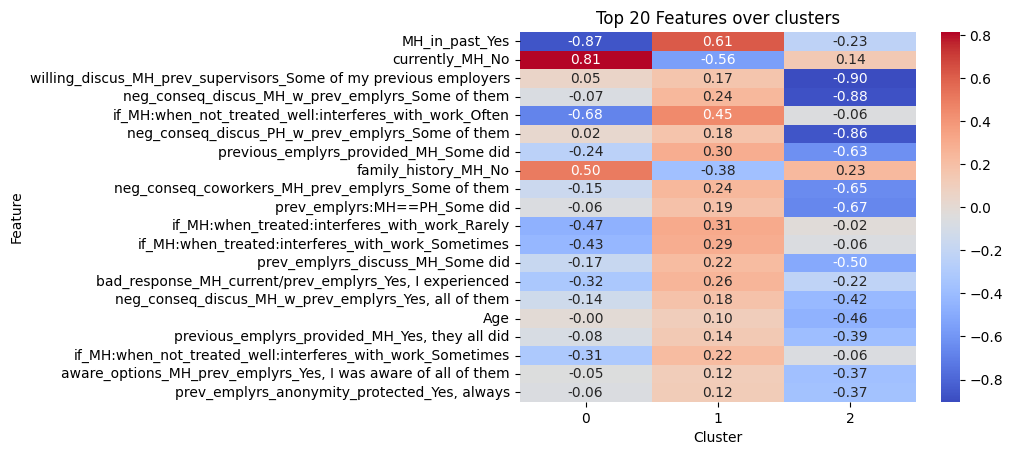

In [132]:
exclude_cols = [
                "Unknown", "Not applicable",
                "MH_in_past_No", "currently_MH_Yes",
                "family_history_MH_Yes",
                ]


filtered_cols = [
    col for col in cluster_summary.columns
    if not any(ex_col in col for ex_col in exclude_cols)
]
"""
filtered_cols = [col for col in cluster_summary.columns 
                 if "unknown" not in col.lower() 
                 and "not applicable" not in col.lower()
                 and "MH_in_past_No" not in col
                 and "currently_MH_Yes" not in col
                 and "family_history_MH_Yes" not in col
                 ]
"""

cluster_summary_filtered = cluster_summary[filtered_cols]
feature_variance = cluster_summary_filtered.std(axis=0)

n_feat = 20
top_features = feature_variance.sort_values(ascending=False).head(n_feat).index.tolist()
print("Top 10 features (with exclusions):", top_features)


#plt.figure(figsize=(20, 3))
#plt.figure(figsize=(10, 30))
#sns.heatmap(cluster_summary_filtered[next_features], cmap="coolwarm", annot=True, fmt=".2f")
sns.heatmap(cluster_summary_filtered[top_features].T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title(f"Top {n_feat} Features over clusters")
plt.xlabel("Cluster")
plt.ylabel("Feature")
#plt.xticks(rotation=90, fontsize=9)
#plt.tight_layout()
plt.savefig(f"final-evaluation-{n_feat}.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

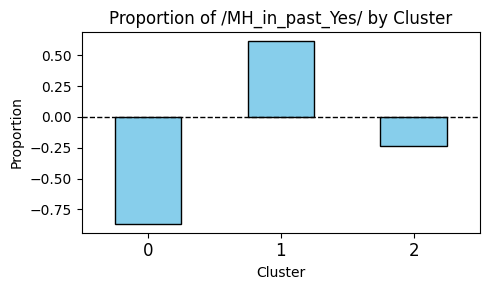

In [ ]:
# test
feat = "MH_in_past_Yes"
proportion = df_data.groupby('cluster')[feat].mean()

plt.figure(figsize=(5, 3))
proportion.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f'Proportion of /{feat}/ by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.xticks(rotation=0, fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


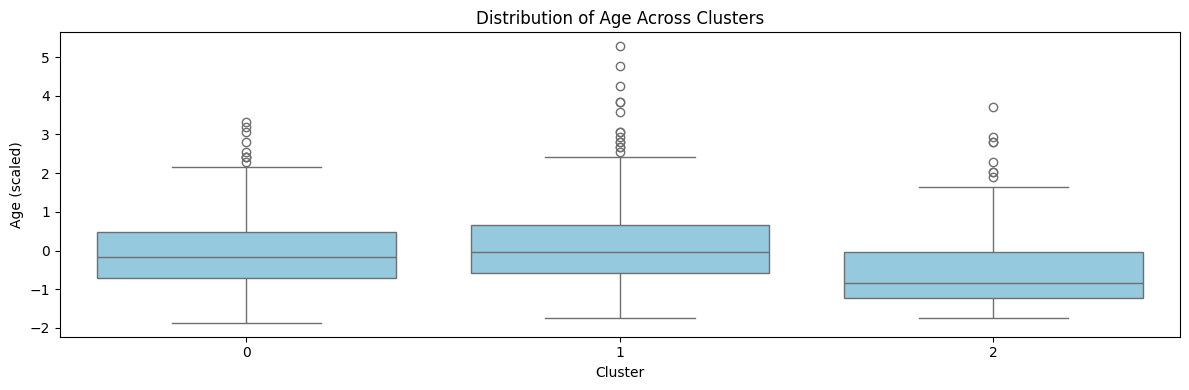

In [142]:
plt.figure(figsize=(12, 4))
sns.boxplot(x='cluster', y='Age', data=df_data, color='skyblue')# palette="Set1")
plt.title('Distribution of Age Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Age (scaled)')
plt.tight_layout()
plt.savefig(f"final-clusters-age.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()


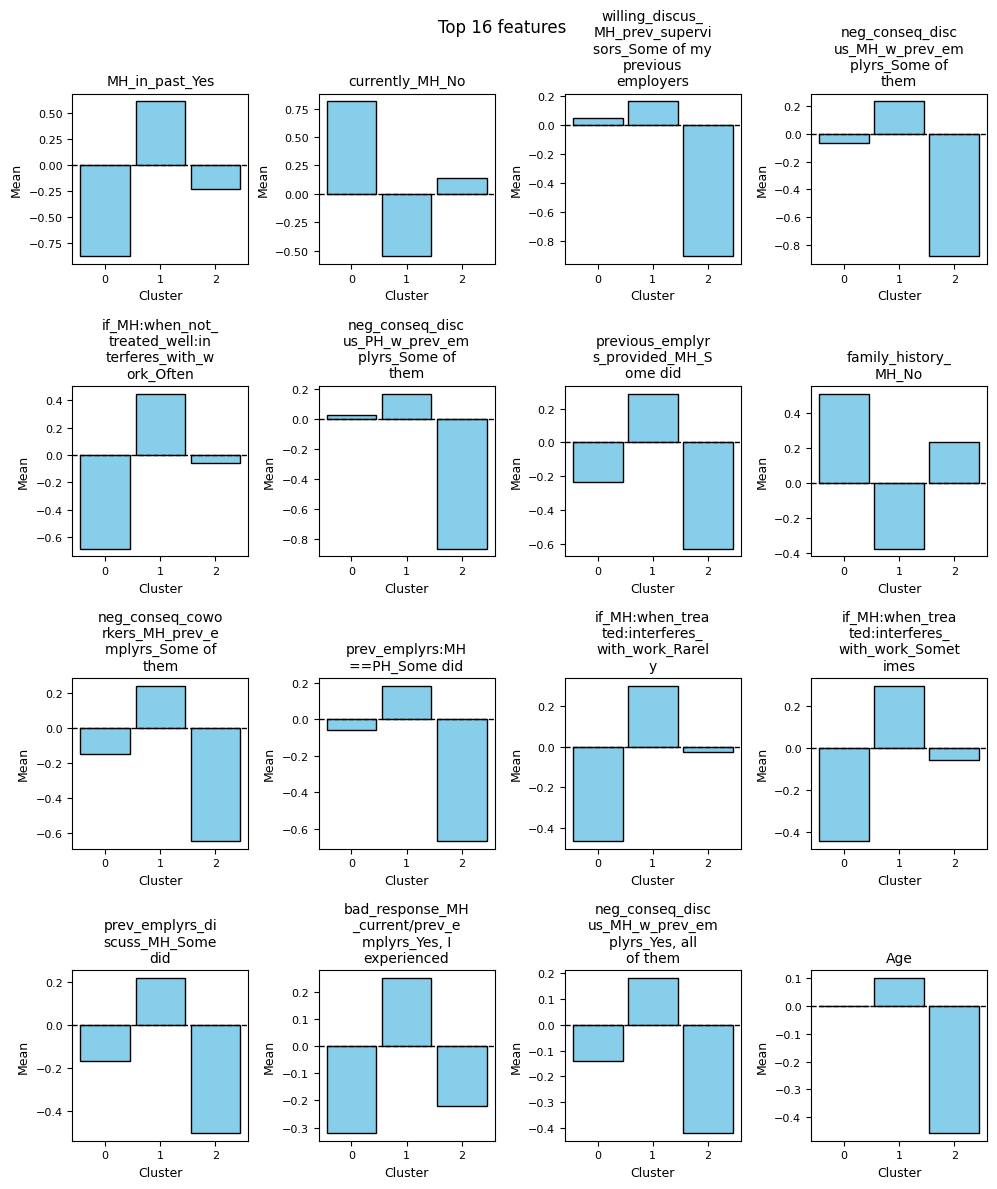

In [ ]:
import textwrap

n_features = 16
#feature_variance = cluster_summary_filtered.std(axis=0)
top_features = feature_variance.sort_values(ascending=False).head(n_features).index.tolist()

n_rows, n_cols = 4, 4
#n_rows, n_cols = int(np.sqrt(n_features)), int(np.sqrt(n_features))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 12))

for i, feat in enumerate(top_features):
    ax = axes[i // n_cols, i % n_cols]
    proportion = df_data.groupby('cluster')[feat].mean()
    
    ax.bar(proportion.index, proportion, color='skyblue', edgecolor='black', width=0.9)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    wrapped_title = textwrap.fill(feat, width=15)
    ax.set_title(wrapped_title, fontsize=10)
    ax.set_xlabel("Cluster", fontsize=9)
    ax.set_ylabel("Mean", fontsize=9)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.suptitle("Top 16 features")
plt.savefig("final-multiplot.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()